# Identifying relationships between annotated omics data in NMDC

In this notebook, we explore how different types of omics data—specifically metagenomic and metatranscriptomic—can be connected through commonly used annotation vocabularies such as biomolecules, taxonomy, and KEGG pathways. Using the **Harvard Forest dataset** as an example, which includes paired and processed metagenomic and metatranscriptomic data available in the NMDC Data Portal, we demonstrate how to link and analyze these data types for integrated interpretation.

In [72]:
# Setup 
# Add renv project library to R environment variable libPaths()
.libPaths(c(.libPaths(), "../../renv/library/*/R-*/*"))

# Load required packages
suppressPackageStartupMessages({
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(readr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(fs)
library(digest)
library(httr)
library(stats)
library(purrr)
library(tibble)
library(jsonlite)
library(KEGGREST)
})

options(repr.plot.width = 12, repr.plot.height = 8)

# Load NMDC API functions from this repo
if(Sys.getenv("COLAB_BACKEND_VERSION") == "") source("../../utility_functions.R")

if(Sys.getenv("COLAB_BACKEND_VERSION") != "") source("http://raw.githubusercontent.com/microbiomedata/nmdc_notebooks/refs/heads/main/utility_functions.R")

## 1. Retrieve data from the NMDC database using API endpoints

### Choose the data you want to explore

The [NMDC Data Portal](https://data.microbiomedata.org/) is a powerful resource where you can search for samples by all kinds of criteria. For this example, we’ll focus on finding samples that have both metagenomics and metatranscriptomics data.  
To do this, just use the Data Type filters (the “upset plot” below the interactive map) to quickly spot the right samples. In our case, these filters lead us to samples from the study [“Jeff Blanchard’s Harvard forest soil project”](https://data.microbiomedata.org/details/study/nmdc:sty-11-8ws97026).

### Get and filter data for Jeff Blanchard’s Harvard forest soil project

Every study in the portal has a unique ID in its URL; for this one, it’s `nmdc:sty-11-8ws97026`.  
We’ll use the function `get_data_objects_for_study` (found in `utility_functions.R`) to pull up all related data records for this project. This includes download links for raw files (like FASTQs) as well as processed outputs from NMDC’s workflows.

> Tip: You can use these data objects to download files directly or to browse the processed results right in the portal!


In [4]:
# Retrieve all data objects associated with this study
dobj <- get_data_objects_for_study("nmdc:sty-11-8ws97026")

One way of further identifying a NMDC `DataObject` record is by looking at its slot `data_object_type` (https://microbiomedata.github.io/nmdc-schema/data_object_type/), which contains a value from `FileTypeEnum` (https://microbiomedata.github.io/nmdc-schema/FileTypeEnum/). 

We want to look at the processed data results for our two omics types of interest in this notebook. Specifically, we want the files containing KEGG Orthology, Taxonomy Lineage, and  Expression data. These expression data is available in file for metatranscriptomics data (in "Metatranscriptome Expression" data object) and annotation data are found together in the metagenomics and metatranscriptomics ( in 'Annotation KEGG Orthology' and 'Gene Phylogeny tsv') results files.

We filter for results files with the following `data_object_type` values:

| Value | Description |
|:-----:|:-----------:|
|Gene Phylogeny tsv|Tab-delimited file of gene phylogeny|
|Annotation KEGG Orthology|Tab delimited file for KO annotation|
|Metatranscriptome Expression|Read count table output|


In [5]:
# 1) Filter to biosamples that have ALL three required data_object_type entries
dobj_filtered <- dobj %>%
  group_by(biosample_id) %>%
  filter(all(c("Annotation KEGG Orthology",
               "Metatranscriptome Expression",
               "Gene Phylogeny tsv") %in% data_object_type)) %>%
  ungroup()

# 2) Keep only the desired file types and select/rename columns
results_by_biosample <- dobj_filtered %>%
  filter(data_object_type %in% c("Annotation KEGG Orthology",
                                 "Metatranscriptome Expression",
                                 "Gene Phylogeny tsv")) %>%
  transmute(
    biosample_id,
    output_id = id,          # rename 'id' -> 'output_id'
    data_object_type,
    url
  )

# 3) Check counts per data_object_type (equivalent to pandas value_counts)
type_counts <- results_by_biosample %>%
  count(data_object_type, name = "n")

# Peek
head(results_by_biosample)
type_counts

biosample_id         output_id             data_object_type            
1 nmdc:bsm-11-042nd237 nmdc:dobj-11-dmr9gp89 Gene Phylogeny tsv          
2 nmdc:bsm-11-042nd237 nmdc:dobj-11-zvfajv89 Gene Phylogeny tsv          
3 nmdc:bsm-11-042nd237 nmdc:dobj-11-x79xrm69 Annotation KEGG Orthology   
4 nmdc:bsm-11-042nd237 nmdc:dobj-11-qb81nz42 Metatranscriptome Expression
5 nmdc:bsm-11-042nd237 nmdc:dobj-11-ywhqd374 Annotation KEGG Orthology   
6 nmdc:bsm-11-127y7152 nmdc:dobj-11-pdd2wh60 Gene Phylogeny tsv          
  url                                                                                                                              
1 https://data.microbiomedata.org/data/nmdc:dgns-11-zayj8368/nmdc:wfmgan-11-fw38xr59.1/nmdc_wfmgan-11-fw38xr59.1_gene_phylogeny.tsv
2 https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtan-11-ryv54x73.1/nmdc_wfmtan-11-ryv54x73.1_gene_phylogeny.tsv
3 https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtan-11-ryv54x73.1/nmdc_wfmtan-11-ryv54x73.1_ko.tsv            
4 https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtex-11-n2w8c804.1/nmdc_wfmtex-11-n2w8c804.1.rnaseq_gea.txt    
5 https://data.microbiomedata.org/data/nmdc:dgns-11-zayj8368/nmdc:wfmgan-11-fw38xr59.1/nmdc_wfmgan-11-fw38xr59.1_ko.tsv            
6 https://data.microbiomedata.org/data/nmdc:dgns-11-cgnpxt22/nmdc:wfmtan-11-ssf5tv34.1/nmdc_wfmtan-11-ssf5tv34.1_gene_phylogeny.tsv

data_object_type             n 
1 Annotation KEGG Orthology    64
2 Gene Phylogeny tsv           64
3 Metatranscriptome Expression 39

### Select data has both metaT and metaG analysis result
Notice that Each biosample is expected to have two lineage TSV files and two KO results. Therefore, the total count should be double the expression data count (39 × 2 = 78).  However, we only observed 64. This indicates that some biosamples contain only one type of data.  

To address this, we need to filter out those incomplete biosamples and retain only those with both metaG and metaT data for the analysis (n=25).

In [6]:
# --- Flag MetaT / MetaG by URL ---
results_by_biosample <- results_by_biosample %>%
  mutate(
    `_has_metaT` = grepl("nmdc:wfmt", url, ignore.case = TRUE),
    `_has_metaG` = grepl("nmdc:wfmg", url, ignore.case = TRUE),
    `_is_annotation` = data_object_type == "Annotation KEGG Orthology",
    `_is_lineage`    = data_object_type == "Gene Phylogeny tsv"
  ) %>%
  # Relabel data_object_type based on flags (use masks computed above)
  mutate(
    data_object_type = case_when(
      `_has_metaT` & `_is_annotation` ~ "MetaT Annotation KEGG Orthology",
      `_has_metaG` & `_is_annotation` ~ "MetaG Annotation KEGG Orthology",
      `_has_metaT` & `_is_lineage`    ~ "MetaT Gene Phylogeny tsv",
      `_has_metaG` & `_is_lineage`    ~ "MetaG Gene Phylogeny tsv",
      TRUE ~ data_object_type
    )
  )

# --- Per-biosample aggregates ---
agg <- results_by_biosample %>%
  group_by(biosample_id) %>%
  summarise(
    rows_per_biosample = n(),
    has_metaT = any(`_has_metaT`, na.rm = TRUE),
    has_metaG = any(`_has_metaG`, na.rm = TRUE),
    metaT_row_count = sum(`_has_metaT`, na.rm = TRUE),
    metaG_row_count = sum(`_has_metaG`, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(
    category = case_when(
      has_metaT & has_metaG ~ "both_metaT_and_metaG",
      has_metaT & !has_metaG ~ "metaT_only",
      has_metaG & !has_metaT ~ "metaG_only",
      TRUE ~ "neither"
    )
  )

# --- Category counts (like value_counts) ---
counts <- agg %>%
  count(category, name = "count") %>%
  arrange(desc(count))

print(counts)

# --- Keep only biosamples with BOTH MetaT and MetaG ---
keep_ids <- agg %>%
  filter(category == "both_metaT_and_metaG") %>%
  pull(biosample_id) %>%
  unique()

drop_ids <- agg %>%
  filter(category != "both_metaT_and_metaG") %>%
  pull(biosample_id) %>%
  unique()

filtered_results_by_biosample <- results_by_biosample %>%
  filter(biosample_id %in% keep_ids) %>%
  select(-`_has_metaT`, -`_has_metaG`, -`_is_annotation`, -`_is_lineage`)

# --- Wide table: one row per biosample, columns = data_object_type, values = url ---
wide <- filtered_results_by_biosample %>%
  select(biosample_id, data_object_type, url) %>%
  pivot_wider(names_from = data_object_type, values_from = url)

head(wide, 10)

# A tibble: 2 × 2
  category             count
  <chr>                <int>
1 both_metaT_and_metaG    25
2 metaT_only              14


biosample_id        
1  nmdc:bsm-11-042nd237
2  nmdc:bsm-11-3p2mnz08
3  nmdc:bsm-11-622k6044
4  nmdc:bsm-11-65a4xw75
5  nmdc:bsm-11-6m6c9g55
6  nmdc:bsm-11-6x067s27
7  nmdc:bsm-11-71991e79
8  nmdc:bsm-11-7m09me46
9  nmdc:bsm-11-7twwzs96
10 nmdc:bsm-11-8rn9bm20
   MetaG Gene Phylogeny tsv                                                                                                         
1  https://data.microbiomedata.org/data/nmdc:dgns-11-zayj8368/nmdc:wfmgan-11-fw38xr59.1/nmdc_wfmgan-11-fw38xr59.1_gene_phylogeny.tsv
2  https://data.microbiomedata.org/data/nmdc:dgns-11-yxhzrq69/nmdc:wfmgan-11-t597cr38.1/nmdc_wfmgan-11-t597cr38.1_gene_phylogeny.tsv
3  https://data.microbiomedata.org/data/nmdc:dgns-11-0g2bvk46/nmdc:wfmgan-11-46sdce04.1/nmdc_wfmgan-11-46sdce04.1_gene_phylogeny.tsv
4  https://data.microbiomedata.org/data/nmdc:dgns-11-w6m8tk08/nmdc:wfmgan-11-mmxw6483.1/nmdc_wfmgan-11-mmxw6483.1_gene_phylogeny.tsv
5  https://data.microbiomedata.org/data/nmdc:dgns-11-4k8jak62/nmdc:wfmgan-11-e4b9rk86.1/nmdc_wfmgan-11-e4b9rk86.1_gene_phylogeny.tsv
6  https://data.microbiomedata.org/data/nmdc:dgns-11-t2ejqy28/nmdc:wfmgan-11-zqn9em82.1/nmdc_wfmgan-11-zqn9em82.1_gene_phylogeny.tsv
7  https://data.microbiomedata.org/data/nmdc:dgns-11-71xjrh06/nmdc:wfmgan-11-8s3ep328.1/nmdc_wfmgan-11-8s3ep328.1_gene_phylogeny.tsv
8  https://data.microbiomedata.org/data/nmdc:dgns-11-hwbrhz12/nmdc:wfmgan-11-1vkd7g49.1/nmdc_wfmgan-11-1vkd7g49.1_gene_phylogeny.tsv
9  https://data.microbiomedata.org/data/nmdc:dgns-11-tsj32b65/nmdc:wfmgan-11-zxmjdh22.1/nmdc_wfmgan-11-zxmjdh22.1_gene_phylogeny.tsv
10 https://data.microbiomedata.org/data/nmdc:dgns-11-wj9yhw60/nmdc:wfmgan-11-njdr0e67.1/nmdc_wfmgan-11-njdr0e67.1_gene_phylogeny.tsv
   MetaT Gene Phylogeny tsv                                                                                                         
1  https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtan-11-ryv54x73.1/nmdc_wfmtan-11-ryv54x73.1_gene_phylogeny.tsv
2  https://data.microbiomedata.org/data/nmdc:dgns-11-sfhj5f74/nmdc:wfmtan-11-qn0rff14.1/nmdc_wfmtan-11-qn0rff14.1_gene_phylogeny.tsv
3  https://data.microbiomedata.org/data/nmdc:dgns-11-yqheg664/nmdc:wfmtan-11-jbbpdz62.1/nmdc_wfmtan-11-jbbpdz62.1_gene_phylogeny.tsv
4  https://data.microbiomedata.org/data/nmdc:dgns-11-mw1vp557/nmdc:wfmtan-11-qcnn8k31.1/nmdc_wfmtan-11-qcnn8k31.1_gene_phylogeny.tsv
5  https://data.microbiomedata.org/data/nmdc:dgns-11-kvhxfz39/nmdc:wfmtan-11-zr9wpb59.1/nmdc_wfmtan-11-zr9wpb59.1_gene_phylogeny.tsv
6  https://data.microbiomedata.org/data/nmdc:dgns-11-hngnz807/nmdc:wfmtan-11-9jpgyv22.1/nmdc_wfmtan-11-9jpgyv22.1_gene_phylogeny.tsv
7  https://data.microbiomedata.org/data/nmdc:dgns-11-5my2te78/nmdc:wfmtan-11-0tmerk58.1/nmdc_wfmtan-11-0tmerk58.1_gene_phylogeny.tsv
8  https://data.microbiomedata.org/data/nmdc:dgns-11-vfdkag98/nmdc:wfmtan-11-17594f10.1/nmdc_wfmtan-11-17594f10.1_gene_phylogeny.tsv
9  https://data.microbiomedata.org/data/nmdc:dgns-11-kf8gwm78/nmdc:wfmtan-11-xbk8hw28.1/nmdc_wfmtan-11-xbk8hw28.1_gene_phylogeny.tsv
10 https://data.microbiomedata.org/data/nmdc:dgns-11-hgn6td61/nmdc:wfmtan-11-wh0e3993.1/nmdc_wfmtan-11-wh0e3993.1_gene_phylogeny.tsv
   MetaT Annotation KEGG Orthology                                                                                      
1  https://data.microbiomedata.org/data/nmdc:dgns-11-2rrxzb57/nmdc:wfmtan-11-ryv54x73.1/nmdc_wfmtan-11-ryv54x73.1_ko.tsv
2  https://data.microbiomedata.org/data/nmdc:dgns-11-sfhj5f74/nmdc:wfmtan-11-qn0rff14.1/nmdc_wfmtan-11-qn0rff14.1_ko.tsv
3  https://data.microbiomedata.org/data/nmdc:dgns-11-yqheg664/nmdc:wfmtan-11-jbbpdz62.1/nmdc_wfmtan-11-jbbpdz62.1_ko.tsv
4  https://data.microbiomedata.org/data/nmdc:dgns-11-mw1vp557/nmdc:wfmtan-11-qcnn8k31.1/nmdc_wfmtan-11-qcnn8k31.1_ko.tsv
5  https://data.microbiomedata.org/data/nmdc:dgns-11-kvhxfz39/nmdc:wfmtan-11-zr9wpb59.1/nmdc_wfmtan-11-zr9wpb59.1_ko.tsv
6  https://data.microbiomedata.org/data/nmdc:dgns-11-hngnz807/nmdc:wfmtan-11-9jpgyv22.1

After filtering out those incomplete biosamples and retaining only those with both metaG and metaT data for the analysis (n=25), we can use `get_biosample_record_by_id` function from `utility_function.R` loaded earlier to retrieve the associated metadata for these biosamples and these will be used for downstream analysis.

In [7]:
# -- Helper: turn length-0 into NA
scalar_or_na <- function(x) if (length(x) == 0) NA else x

# -- Helper: extract has_raw_value; keep multi-valued as list-col
extract_value <- function(value) {
  # If it's a list with has_raw_value, return that scalar
  if (is.list(value) && "has_raw_value" %in% names(value)) {
    return(scalar_or_na(value$has_raw_value))
  }
  # If it's an atomic vector of length > 1, wrap as list-column
  if (is.atomic(value) && length(value) > 1) {
    return(list(value))
  }
  # If it's a complex/named list without has_raw_value, keep as list-col
  if (is.list(value) && length(value) > 1) {
    return(list(value))
  }
  # Fallback: scalar or length-0 -> NA
  scalar_or_na(value)
}

# -- Optional: collapse list-cols that are atomic vectors into a single string
collapse_multi_vals <- function(x, sep = "; ") {
  if (is.list(x) && length(x) == 1 && is.atomic(x[[1]]) && length(x[[1]]) > 1) {
    return(paste(x[[1]], collapse = sep))
  }
  x
}

# --- Main: flatten biosample records into a tibble
# Set collapse_multi = TRUE if you want plain strings instead of list-cols
biosample_records_to_table <- function(biosample_records, collapse_multi = TRUE, sep = "; ") {
  rows <- map(biosample_records, function(data) {
    if (is.null(data)) return(NULL)
    flat <- map(data, extract_value)

    if (collapse_multi) {
      flat <- lapply(flat, collapse_multi_vals, sep = sep)
    }

    as_tibble(flat, .name_repair = "unique")
  })

  df <- bind_rows(rows) %>%
    rename(biosample_id = id)

  df
}


biosample_ids <- unique(wide$biosample_id)
biosample_records <- map(biosample_ids, get_biosample_record_by_id)

# Keep multi-valued fields as list-columns (safe for further processing)
biosample_metadata <- biosample_records_to_table(biosample_records)

# Save
write_csv(biosample_metadata, "biosample_metadata.csv")

### Download selected results files
 
Now we can use the `url` slots from the filtered `DataObject` records to read in the files containing the annotations of interest and stored in a `datastore` data structure.

* The “datastore” is just a tiny index (strings), not nested data frames.
* Read only what you need for the current computation, then let R GC the rest.
* Caching avoids re-downloading and speeds up re-runs.


In [ ]:
# Reuse your domain normalizer
# Vectorized URL normalizer (handles character, list-cols, NA/empty, "nan")
normalize_nmdc_url <- function(url) {
  # If list-column, take first element per cell (or NA)
  if (is.list(url)) {
    url <- vapply(
      url,
      function(x) if (length(x) == 0) NA_character_ else as.character(x[[1]]),
      character(1)
    )
  }
  url <- as.character(url)

  # Normalize empties / sentinel strings to NA
  bad <- is.na(url) | !nzchar(url) | tolower(url) %in% c("nan", "na", "null", "none")
  url[bad] <- NA_character_

  # Rewrite domain
  url <- str_replace(url,
                     "^https://data\\.microbiomedata\\.org",
                     "https://data-backup.microbiomedata.org")
  url
}

# Build a *lightweight* datastore index: just IDs + URLs (no data loaded)
build_datastore_index <- function(wide_df) {
  stopifnot(all(c("biosample_id") %in% names(wide_df)))

  # These column names must match your wide table’s columns
  cols_needed <- c(
    "MetaG Annotation KEGG Orthology",
    "MetaT Annotation KEGG Orthology",
    "MetaG Gene Phylogeny tsv",
    "MetaT Gene Phylogeny tsv",
    "Metatranscriptome Expression"
  )
  missing <- setdiff(cols_needed, names(wide_df))
  if (length(missing)) stop("Missing columns in `wide_df`: ", paste(missing, collapse = ", "))

  wide_df %>%
    transmute(
      biosample_id,
      metag_ko_url      = normalize_nmdc_url(`MetaG Annotation KEGG Orthology`),
      metat_ko_url      = normalize_nmdc_url(`MetaT Annotation KEGG Orthology`),
      metag_lineage_url = normalize_nmdc_url(`MetaG Gene Phylogeny tsv`),
      metat_lineage_url = normalize_nmdc_url(`MetaT Gene Phylogeny tsv`),
      metat_expr_url    = normalize_nmdc_url(`Metatranscriptome Expression`)
    )
}
# Column specs
ko_columns <- c(
  "gene_id","img_ko_flag","ko_term","percent_identity",
  "query_start","query_end","subj_start","subj_end",
  "evalue","bit_score","align_length"
)
lineage_columns <- c("gene_id","homolog_gene_oid","homolog_taxon_oid","percent_identity","lineage")

# With cache: save to cache_dir/<hash>.tsv then read locally
read_tsv_cached <- function(url, column_names = NULL, cache_dir = "data_cache",
                            max_retries = 3, sleep_seconds = 2) {
  if (is.na(url) || is.null(url) || url == "" || identical(tolower(url), "nan")) return(NULL)

  dir_create(cache_dir)
  key <- digest(url, algo = "xxhash64")
  local_path <- path(cache_dir, paste0(key, ".tsv"))

  # If cached, just read
  if (file_exists(local_path)) {
    col_names_arg <- if (is.null(column_names)) TRUE else column_names
    return(tryCatch(
      readr::read_tsv(local_path, col_names = col_names_arg, show_col_types = FALSE, progress = FALSE),
      error = function(e) { warning("Failed to read cached: ", local_path, " : ", e$message); NULL }
    ))
  }

  # Else, try download+read (retry)
  attempt <- 1
  while (attempt <= max_retries) {
    tryCatch({
      message(sprintf("Downloading: %s (attempt %d)", url, attempt))
      # Download to temp then move into cache (atomic)
      tmp <- tempfile(fileext = ".tsv")
      utils::download.file(url, destfile = tmp, mode = "wb", quiet = TRUE)
      file_move(tmp, local_path)

      col_names_arg <- if (is.null(column_names)) TRUE else column_names
      return(readr::read_tsv(local_path, col_names = col_names_arg, show_col_types = FALSE, progress = FALSE))
    },
    error = function(e) {
      warning(sprintf("Attempt %d failed for %s: %s", attempt, url, e$message))
      if (attempt < max_retries) Sys.sleep(sleep_seconds * attempt)
    })
    attempt <- attempt + 1
  }

  warning("❌ Failed after retries: ", url)
  NULL
}

# Accessors (read only what’s asked for)
load_ko_table <- function(url) {
  read_tsv_cached(url, column_names = ko_columns)
}
load_lineage_table <- function(url) {
  read_tsv_cached(url, column_names = lineage_columns)
}
load_expr_table <- function(url) {
  read_tsv_cached(url, column_names = NULL)  # header inferred
}

#   Build the lightweight index from your wide table
#    (wide has biosample_id + the 5 columns from the pivot step)
datastore_index <- build_datastore_index(wide)
# Check total number of biosamples & preview one file ---
cat("# of biosamples: ", length(datastore_index$biosample_id), "\n")


# of biosamples:  25 


## 2. KEGG Orthology (KO) Analysis
### Shared vs unique KOs (MetaG vs MetaT)
 
Metagenomic and metatranscriptome results in NMDC both include KEGG Orthology (KO) annotations. This allows us to compare the shared and unique KOs between the two data types across biosamples.

Technically, we parse the KO TSV files for both MetaG and MetaT, standardize the KO IDs (Kxxxxx format), and calculate the following for each biosample:

 * Number of MetaG KOs (n_metag_ko)
 * Number of MetaT KOs (n_metat_ko)
 * Number of shared KOs (n_shared_ko)
 * Number unique to MetaG (n_metag_only)
 * Number unique to MetaT (n_metat_only)
 * Jaccard index

Additionally, we generate a stacked bar chart to visualize the comparison of shared and unique KOs for each biosample. We also create a violin plot or stacked bar chart to compare the distribution of shared KOs across different ecosystems.

In [78]:
# Output directory (same behavior as Python's os.getcwd())
OUTPUT_DIR <- getwd()

# Extract KO id like "K#####"
extract_ko_id <- function(x) {
  if (!is.character(x)) return(NA_character_)
  m <- str_extract(toupper(x), "K\\d{5}")
  m
}

# Standardize a KO dataframe
standardize_ko_df <- function(df_ko) {
  # Return an empty tibble if NULL or 0 rows
  if (is.null(df_ko) || nrow(df_ko) == 0) {
    return(tibble(gene_id = character(), ko_id = character(), ko_term = character()))
  }
  needed <- c("gene_id", "ko_term")
  missing_cols <- setdiff(needed, names(df_ko))
  if (length(missing_cols) > 0) {
    stop(sprintf("KO file missing required column(s): %s.", paste(missing_cols, collapse = ", ")))
  }

  out <- df_ko %>%
    mutate(
      ko_id = vapply(ko_term, extract_ko_id, FUN.VALUE = character(1)),
      gene_id = as.character(.data$gene_id)
    ) %>%
    filter(!is.na(ko_id)) %>%
    select(gene_id, ko_id, ko_term) %>%
    distinct()

  out
}

# Compute per-biosample KO overlap stats (MetaG vs MetaT)
compute_ko_overlap_streaming <- function(datastore_index) {
  purrr::pmap_dfr(
    datastore_index %>%
      select(biosample_id, metag_ko_url, metat_ko_url) %>%
      mutate(row_id = row_number()) %>%
      arrange(row_id),
    function(biosample_id, metag_ko_url, metat_ko_url, row_id) {

      # Read only the two KO tables we need for this sample
      metag <- standardize_ko_df(load_ko_table(metag_ko_url))
      metat <- standardize_ko_df(load_ko_table(metat_ko_url))

      mg <- unique(metag$ko_id)
      mt <- unique(metat$ko_id)
      shared <- intersect(mg, mt)
      uni <- union(mg, mt)

      tibble(
        biosample_id = biosample_id,
        n_metag_ko   = length(mg),
        n_metat_ko   = length(mt),
        n_shared_ko  = length(shared),
        n_metag_only = length(setdiff(mg, mt)),
        n_metat_only = length(setdiff(mt, mg)),
        jaccard      = if (length(uni) > 0) length(shared) / length(uni) else NA_real_
      )
    }
  )
}

# Run and save
ko_overlap_df <- compute_ko_overlap_streaming(datastore_index)

write_csv(ko_overlap_df, file.path(OUTPUT_DIR, "ko_overlap_summary.csv"))

# Show a peek
print(head(ko_overlap_df, 20))
message("Saved: ", file.path(OUTPUT_DIR, "ko_overlap_summary.csv"))

# A tibble: 20 × 7
   biosample_id      n_metag_ko n_metat_ko n_shared_ko n_metag_only n_metat_only
   <chr>                  <int>      <int>       <int>        <int>        <int>
 1 nmdc:bsm-11-042n…       9520       9888        8311         1209         1577
 2 nmdc:bsm-11-3p2m…       9485       8143        7244         2241          899
 3 nmdc:bsm-11-622k…       9101       9447        7790         1311         1657
 4 nmdc:bsm-11-65a4…       8996       8617        7266         1730         1351
 5 nmdc:bsm-11-6m6c…       9490       7938        6975         2515          963
 6 nmdc:bsm-11-6x06…       9693       7547        6806         2887          741
 7 nmdc:bsm-11-7199…       9227       8360        7197         2030         1163
 8 nmdc:bsm-11-7m09…       9330       7412        6578         2752          834
 9 nmdc:bsm-11-7tww…       9569       7738        6759         2810          979
10 nmdc:bsm-11-8rn9…       9173       8649        7409         1764         1240
11 nmdc:b

Saved: /Users/andylo/Projects/NMDC/nmdc_notebooks/metaG_metaT_integration/R/ko_overlap_summary.csv



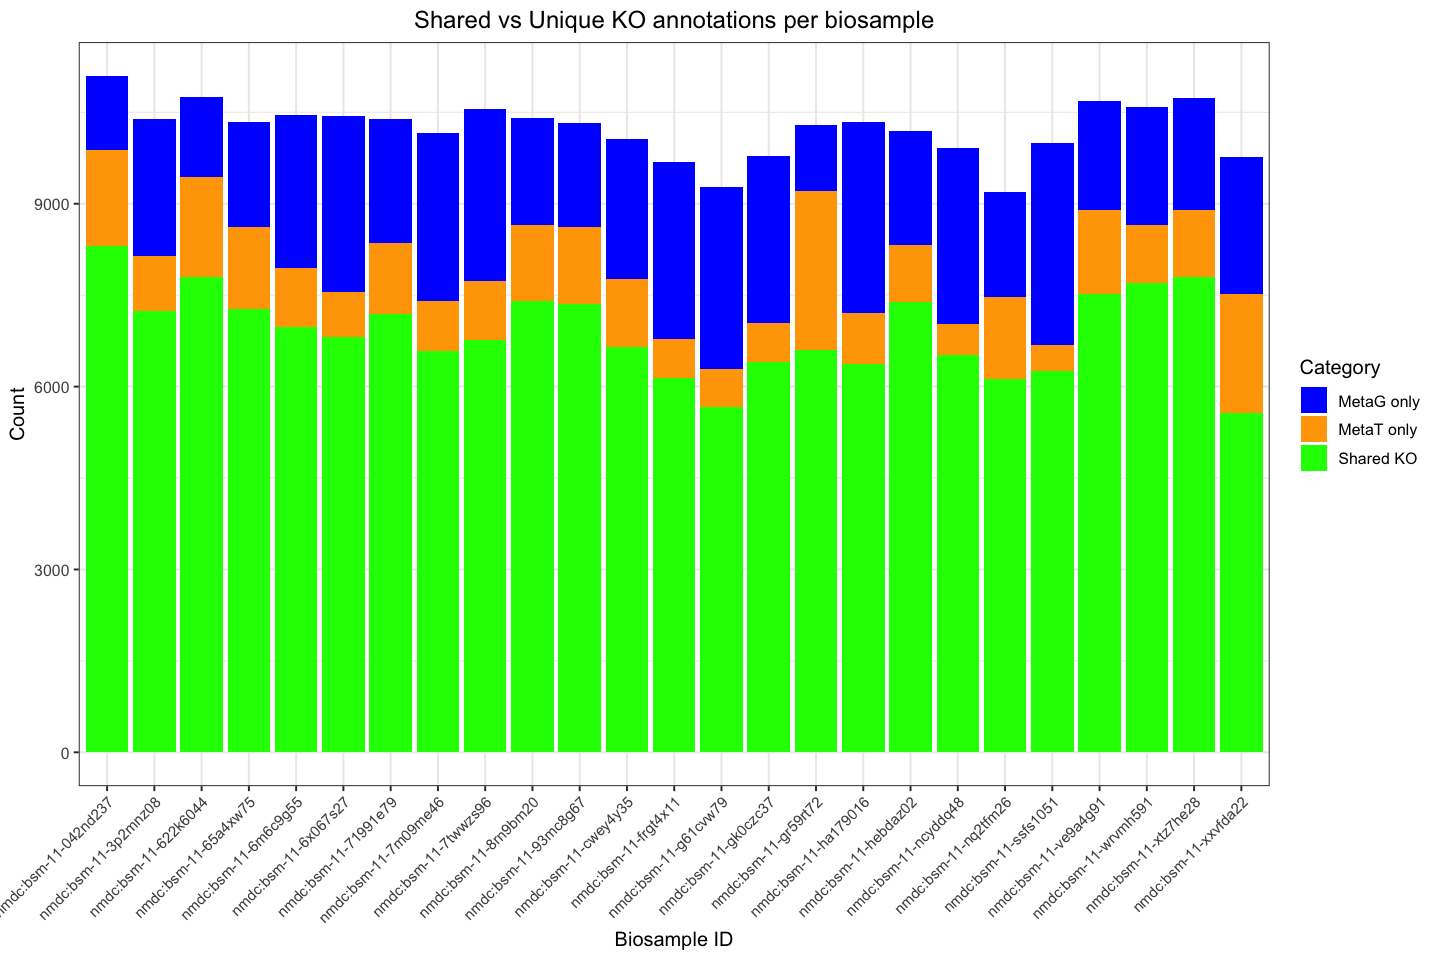

In [79]:
OUTPUT_DIR <- getwd()
html_path  <- file.path(OUTPUT_DIR, "plot_shared_ko_barchart.html")
ko_overlap_df_path <- file.path(OUTPUT_DIR, "ko_overlap_summary.csv")
# -------- Load data (prefer CSV if present) --------
if (file.exists(ko_overlap_df_path)) {
  ko_overlap_df <- readr::read_csv(ko_overlap_df_path, show_col_types = FALSE)
} else if (exists("ko_overlap_df")) {
  message("Using in-memory ko_overlap_df (CSV not found).")
} else {
  stop("ko_overlap_summary.csv not found and ko_overlap_df not in memory.")
}

# Nothing to plot?
if (nrow(ko_overlap_df) == 0) {
  stop("ko_overlap_df is empty; nothing to plot.")
}

# ---- Reshape to long format ----
df_long <- ko_overlap_df %>%
  pivot_longer(
    cols = c(n_metag_only, n_metat_only, n_shared_ko),
    names_to = "category",
    values_to = "count"
  ) %>%
  mutate(
    category = factor(
      category,
      levels = c("n_metag_only", "n_metat_only", "n_shared_ko"),
      labels = c("MetaG only", "MetaT only", "Shared KO")
    )
  )

# Optional: order biosamples by total count (for better visual sorting)
sample_order <- df_long %>%
  group_by(biosample_id) %>%
  summarise(total = sum(count, na.rm = TRUE), .groups = "drop") %>%
  arrange(desc(total)) %>%
  pull(biosample_id)

#df_long <- df_long %>%
#  mutate(biosample_id = factor(biosample_id, levels = sample_order))

# ---- Define color map (same as Python: blue, orange, green) ----
cat_colors <- c("MetaG only" = "blue", "MetaT only" = "orange", "Shared KO" = "green")

# ---- Plot with ggplot2 ----
p <- ggplot(df_long, aes(x = biosample_id, y = count, fill = category)) +
  geom_bar(stat = "identity", position = "stack") +
  scale_fill_manual(values = cat_colors, name = "Category") +
  labs(
    title = "Shared vs Unique KO annotations per biosample",
    x = "Biosample ID",
    y = "Count"
  ) +
  theme_bw(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 9),
    plot.title = element_text(hjust = 0.5)
  )

# ---- Display in R session ----
print(p)

This figure indicates that a substantial portion of the metagenomic functional potential is actively expressed, while the metagenome also contains many KOs with no corresponding transcripts (possibly dormant or low-expression genes). Likewise, a number of KOs appear only in the metatranscriptome, which could arise from highly expressed genes of low abundance organisms or unassembled genomic fragments. Some “metatranscriptome-only KOs” could actually be present in DNA but missing from metagenomic assemblies due to coverage gaps, strain variation, or assembly fragmentation.

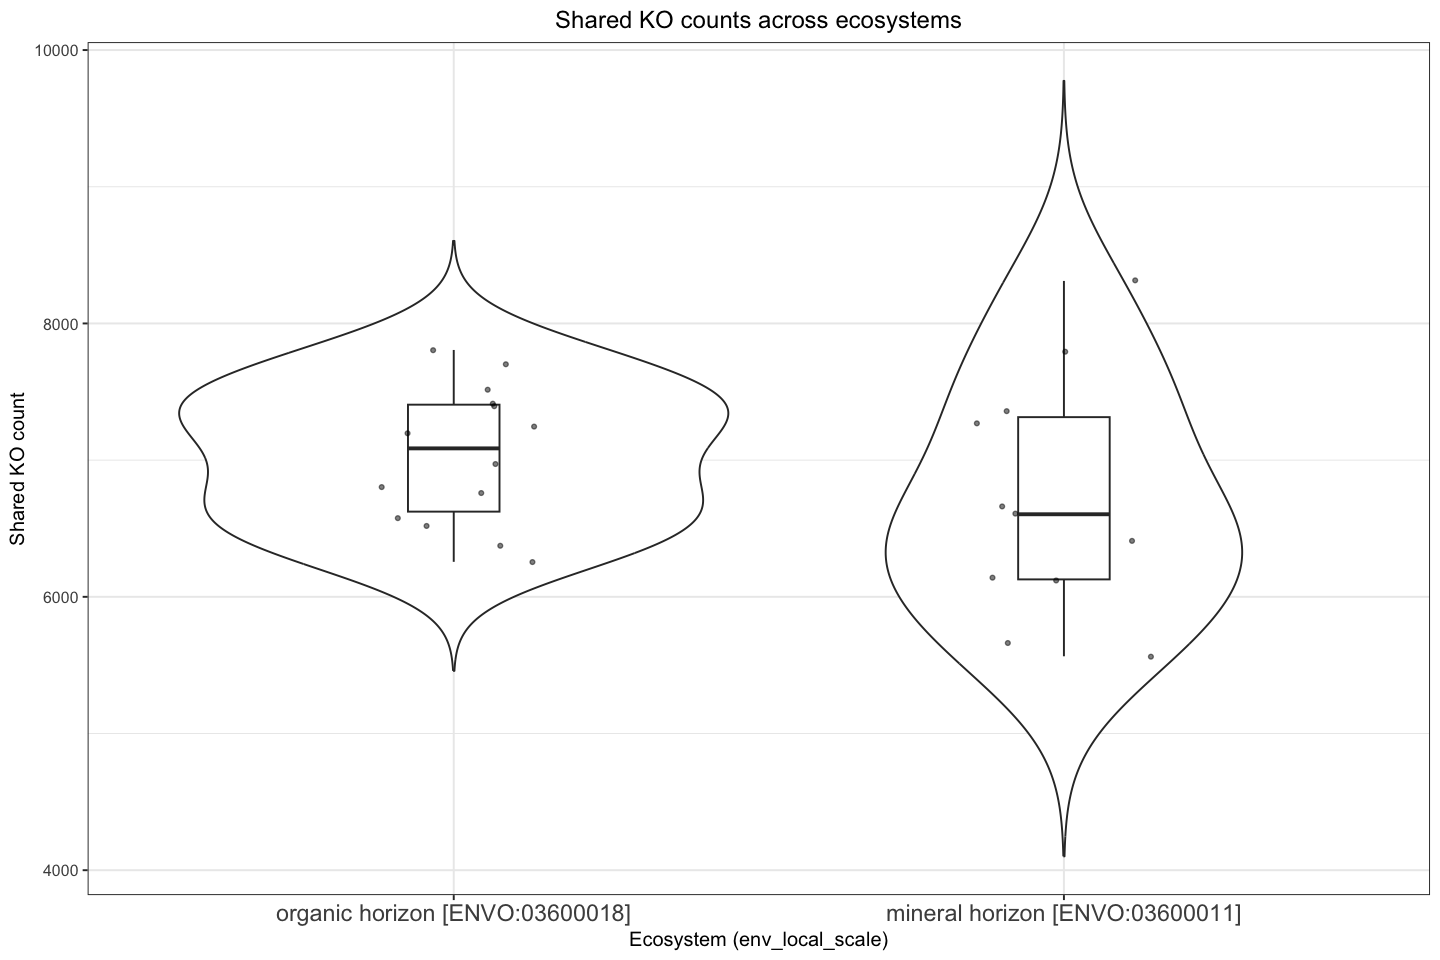

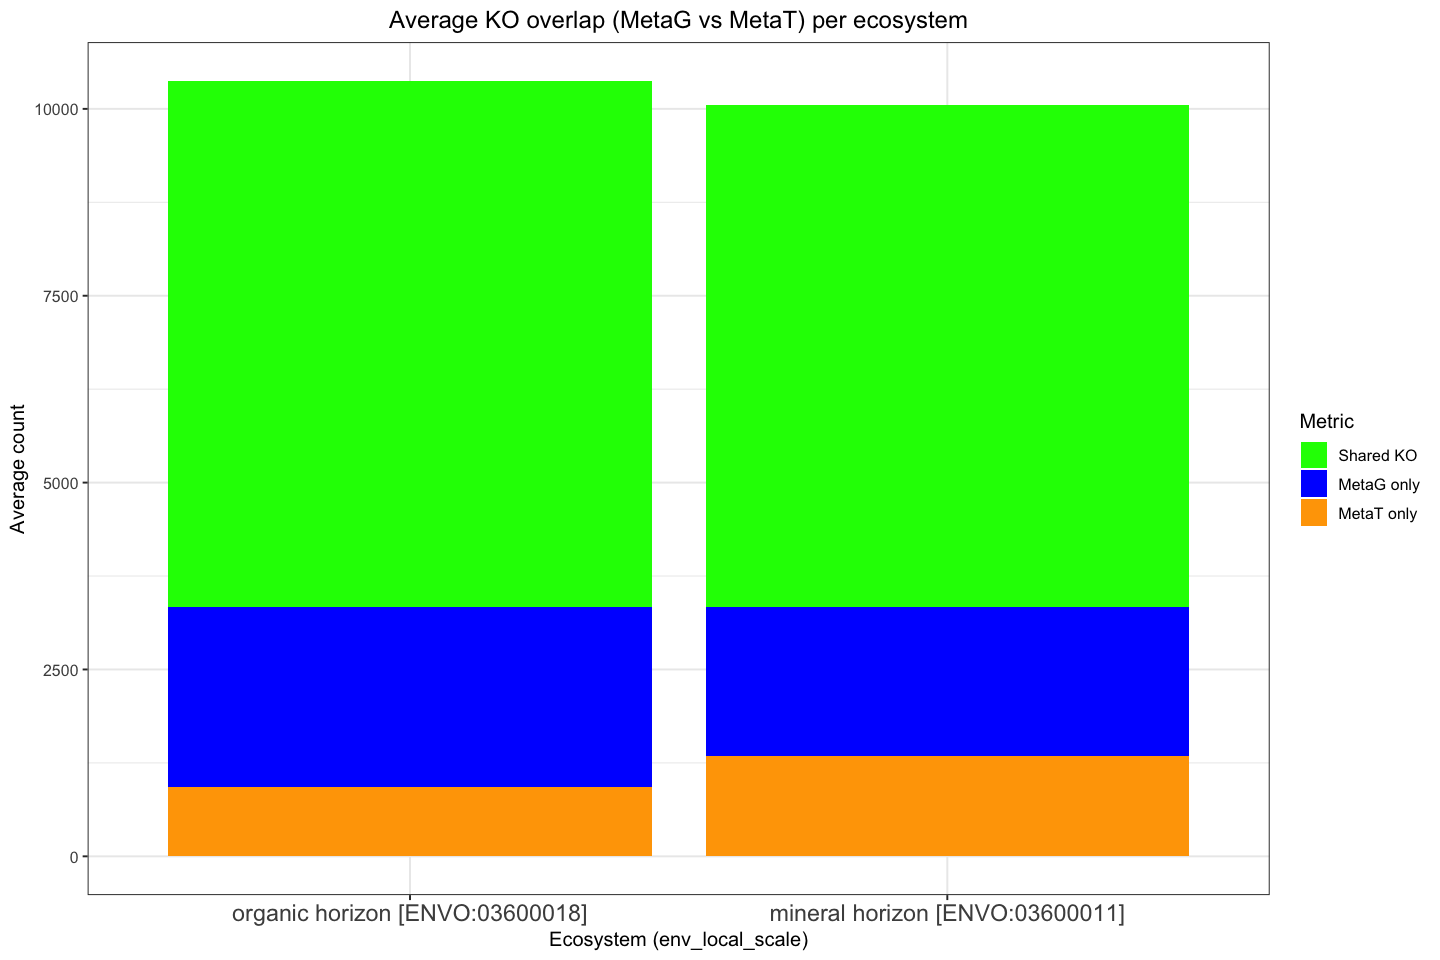

In [80]:
# Join metadata (left join on biosample_id)
ko_with_meta <- ko_overlap_df %>%
  left_join(
    biosample_metadata %>% select(biosample_id, env_local_scale),
    by = "biosample_id"
  )

# ---------------------------
# 1) Violin plot (with box + points): n_shared_ko by ecosystem
# ---------------------------
if (nrow(ko_with_meta) > 0) {
  # order ecosystems by median shared KO (optional, for nicer layout)
  eco_order <- ko_with_meta %>%
    group_by(env_local_scale) %>%
    summarise(med = median(n_shared_ko, na.rm = TRUE), .groups = "drop") %>%
    arrange(desc(med)) %>%
    pull(env_local_scale)

  ko_with_meta <- ko_with_meta %>%
    mutate(env_local_scale = factor(env_local_scale, levels = eco_order))

  p_violin <- ggplot(ko_with_meta, aes(x = env_local_scale, y = n_shared_ko)) +
    geom_violin(trim = FALSE) +
    geom_boxplot(width = 0.15, outlier.shape = NA) +
    geom_jitter(width = 0.15, alpha = 0.5, size = 1) +
    labs(
      title = "Shared KO counts across ecosystems",
      x = "Ecosystem (env_local_scale)",
      y = "Shared KO count"
    ) +
    theme_bw(base_size = 12) +
    theme(
      axis.text.x = element_text(size=14),
      plot.title = element_text(hjust = 0.5)
    )

  print(p_violin)
}

# ---------------------------
# 2) Stacked bars of mean overlap metrics per ecosystem
# ---------------------------
eco_summary <- ko_with_meta %>%
  group_by(env_local_scale) %>%
  summarise(
    n_shared_ko  = mean(n_shared_ko,  na.rm = TRUE),
    n_metag_only = mean(n_metag_only, na.rm = TRUE),
    n_metat_only = mean(n_metat_only, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_longer(
    cols = c(n_shared_ko, n_metag_only, n_metat_only),
    names_to = "metric",
    values_to = "value"
  ) %>%
  mutate(
    metric = factor(
      metric,
      levels = c("n_shared_ko", "n_metag_only", "n_metat_only"),
      labels = c("Shared KO", "MetaG only", "MetaT only")
    ),
    env_local_scale = factor(env_local_scale, levels = eco_order)
  )

if (nrow(eco_summary) > 0) {
  color_map <- c("Shared KO" = "green", "MetaG only" = "blue", "MetaT only" = "orange")

  p_bar <- ggplot(eco_summary, aes(x = env_local_scale, y = value, fill = metric)) +
    geom_col(position = "stack") +
    scale_fill_manual(values = color_map, name = "Metric") +
    labs(
      title = "Average KO overlap (MetaG vs MetaT) per ecosystem",
      x = "Ecosystem (env_local_scale)",
      y = "Average count"
    ) +
    theme_bw(base_size = 12) +
    theme(
      axis.text.x = element_text(size = 14),
      plot.title = element_text(hjust = 0.5)
    )

  print(p_bar)
}


Violin plot of shared KO counts across ecosystems shows the distribution of the number of shared KOs (MetaG ∩ MetaT) for each biosample within ecosystems.

* Functional overlap between potential (DNA) and activity (RNA) is relatively consistent across ecosystems, but variability is greater in mineral horizon, perhaps reflecting more heterogeneous communities or microenvironments.
* With slightly higher shared KO counts on average, organic horizon may support more consistently active functional repertoires due to richer nutrient availability and microbial activity.

Stacked bar chart of average KO categories per ecosystem

* Both ecosystems show a strong backbone of shared functions.
* Mineral horizon → bias toward transcriptome-only functions (active niche-specialized expression).
* Organic horizon → bias toward metagenome-only functions (large reservoir of potential functions not currently expressed).


## 3. KEGG Pathway Analysis

Next, we use the KEGG API to look up KO annotations and determine their corresponding pathways in KEGG.

We calcudate KEGG pathway coverage & expression across biosamples:

* Aggregate MetaT expression data at the pathway level and summarize coverage for each pathway and sample:

	* Number of MetaG KOs (n_metag_kos)
	* Number of MetaT KOs (n_metat_kos)
	* Number of shared KOs (n_shared_kos)

* Aggregate by biosamples to compare the KO count per pathway among shared, metag_only, metat_only and env_local_scale. 

* Generate heatmaps to visualize:

    * Pathway expression (log1p-transformed expression values) by env_local_scale
	* Pathway coverage (counts of shared or modality-specific KOs) by env_local_scale

* Statistics across biosamples and pathways:

	* Perform non-parametric Kruskal–Wallis testing to compare pathway expression distributions across biosamples, with Benjamini–Hochberg FDR correction.

* Visualize top pathways by expression using violin or box plots.

In [ ]:
RUN_KEGG_MAPPING <- TRUE
CACHE_DIR <- getwd()

# --- Helpers ---
.ensure_cache <- function(dir) {
  if (!dir.exists(dir)) dir.create(dir, recursive = TRUE)
  invisible(dir)
}
.strip_prefix <- function(x, db) sub(paste0("^", db, ":"), "", x)

# ============== 1) KO -> Pathway links (cache + KEGGREST) ==============
# Returns tibble: ko_id, pathway_id (e.g., "K00001", "map00010")
kegg_link_ko_to_pathways <- function(ko_ids,
                                     cache_dir = CACHE_DIR,
                                     run_mapping = RUN_KEGG_MAPPING,
                                     chunk_size = 50) {
  # sanitize
  ko_ids <- sort(unique(ko_ids[grepl("^K\\d{5}$", ko_ids)]))
  if (length(ko_ids) == 0) {
    return(tibble(ko_id = character(), pathway_id = character()))
  }

  .ensure_cache(cache_dir)
  cache_path <- file.path(cache_dir, "kegg_ko_pathway_map.tsv")
  cached <- if (file.exists(cache_path)) {
    suppressMessages(readr::read_tsv(cache_path, col_types = "cc"))
  } else {
    tibble(ko_id = character(), pathway_id = character())
  }

  # which KOs not in cache at all?
  cached_kos <- unique(cached$ko_id)
  missing <- setdiff(ko_ids, cached_kos)

  new_rows <- tibble(ko_id = character(), pathway_id = character())

  if (run_mapping && length(missing) > 0) {
    # KEGGREST supports vectorized calls; chunk to be gentle
    chunks <- split(missing, ceiling(seq_along(missing) / chunk_size))
    for (vec in chunks) {
      # Build "ko:" IDs
      ko_q <- paste0("ko:", vec)
      # keggLink("pathway", c("ko:K00001","ko:K00002",...))
      res <- tryCatch(KEGGREST::keggLink("pathway", ko_q),
                      error = function(e) { message("[KEGG] link error: ", e$message); character(0) })

      if (length(res)) {
        # res is a named character vector: values are "path:map#####", names are "ko:K#####"
        add <- tibble(
          ko_id      = .strip_prefix(names(res), "ko"),
          pathway_id = .strip_prefix(unname(res), "path")
        ) %>% distinct()
        new_rows <- bind_rows(new_rows, add)
      } else {
        # no mappings returned for this chunk; still add missing as 0-row (do nothing)
        NULL
      }
    }

    if (nrow(new_rows)) {
      cached <- bind_rows(cached, new_rows) %>% distinct()
      readr::write_tsv(cached, cache_path)
    }
  }

  # Return only the rows for requested ko_ids
  cached %>%
    filter(ko_id %in% ko_ids) %>%
    distinct()
}

# ============== 2) Pathway ID -> Pathway name (cache + KEGGREST) ==============
# Returns tibble: pathway_id (map#####), pathway_name (string)
kegg_pathway_names <- function(pathway_ids,
                               cache_dir = CACHE_DIR,
                               run_mapping = RUN_KEGG_MAPPING,
                               chunk_size = 50) {
  # sanitize
  pathway_ids <- sort(unique(pathway_ids[grepl("^map\\d{5}$", pathway_ids)]))
  if (length(pathway_ids) == 0) {
    return(tibble(pathway_id = character(), pathway_name = character()))
  }

  .ensure_cache(cache_dir)
  cache_path <- file.path(cache_dir, "kegg_pathway_names.tsv")
  cached <- if (file.exists(cache_path)) {
    suppressMessages(readr::read_tsv(cache_path, col_types = "cc"))
  } else {
    tibble(pathway_id = character(), pathway_name = character())
  }
  cached_dict <- cached %>% distinct(pathway_id, pathway_name)

  missing <- setdiff(pathway_ids, cached_dict$pathway_id)
  new_rows <- tibble(pathway_id = character(), pathway_name = character())

  if (run_mapping && length(missing) > 0) {
    chunks <- split(missing, ceiling(seq_along(missing) / chunk_size))
    for (vec in chunks) {
      # KEGG ids must be "path:map00010" etc.
      path_q <- paste0("path:", vec)
      # keggList returns a named character vector: names=pathway IDs, values=names
      lst <- tryCatch(KEGGREST::keggList(path_q),
                      error = function(e) { message("[KEGG] list error: ", e$message); character(0) })
      if (length(lst)) {
        add <- tibble(
          pathway_id   = .strip_prefix(names(lst), "path"),
          pathway_name = unname(lst)
        ) %>% distinct()
        new_rows <- bind_rows(new_rows, add)
      }
    }

    if (nrow(new_rows)) {
      cached <- bind_rows(cached, new_rows) %>% distinct()
      readr::write_tsv(cached, cache_path)
    }
  }

  cached %>%
    filter(pathway_id %in% pathway_ids) %>%
    distinct()
}

# ============== 3) Build KO -> Pathway(+name) map from your datastore ==============
# build_ko_to_pathway_mapping:
# - datastore_index: data frame with at least 'metag_ko_url' (optionally 'metat_ko_url')
# - include_metat: if TRUE and 'metat_ko_url' exists, also load MetaT KO tables
build_ko_to_pathway_mapping <- function(datastore_index,
                                        cache_dir = CACHE_DIR,
                                        run_mapping = RUN_KEGG_MAPPING,
                                        include_metat = FALSE) {
  stopifnot("metag_ko_url" %in% names(datastore_index))

  # Collect KO ids by loading tables from URLs on demand
  urls_metag <- datastore_index$metag_ko_url

  kos_metag <- map(urls_metag, ~ {
    df <- load_ko_table(.x)                # <- uses your cached/retry loader
    std <- standardize_ko_df(df)           # <- ensures gene_id, ko_id, ko_term
    std$ko_id
  }) %>%
    unlist(use.names = FALSE) %>%
    unique()

  kos_all <- kos_metag

  # Optionally include MetaT KOs if column exists and requested
  if (isTRUE(include_metat) && "metat_ko_url" %in% names(datastore_index)) {
    urls_metat <- datastore_index$metat_ko_url
    kos_metat <- map(urls_metat, ~ {
      df <- load_ko_table(.x)
      std <- standardize_ko_df(df)
      std$ko_id
    }) %>%
      unlist(use.names = FALSE) %>%
      unique()
    kos_all <- unique(c(kos_metag, kos_metat))
  }

  kos_all <- sort(kos_all[!is.na(kos_all) & grepl("^K\\d{5}$", kos_all)])
  if (length(kos_all) == 0) {
    return(tibble(ko_id = character(), pathway_id = character(), pathway_name = character()))
  }

  # KO -> pathway mapping (cached)
  ko2path <- kegg_link_ko_to_pathways(kos_all,
                                      cache_dir  = cache_dir,
                                      run_mapping = run_mapping)

  # Pathway names (cached)
  path_names <- if (nrow(ko2path)) {
    kegg_pathway_names(unique(ko2path$pathway_id),
                       cache_dir  = cache_dir,
                       run_mapping = run_mapping)
  } else {
    tibble(pathway_id = character(), pathway_name = character())
  }

  ko2path %>%
    left_join(path_names, by = "pathway_id") %>%
    distinct()
}

ko_path_map <- build_ko_to_pathway_mapping(datastore_index, include_metat=TRUE)  # MetaG + MetaT
head(ko_path_map, 10)

In [ ]:
# ---- 1) Parse MetaT expression (unchanged helper) ----
parse_expression_df <- function(df_expr) {
  gene_col <- "img_gene_oid"
  expr_col <- "reads_cnt"
  OUT_gene_col <- "gene_id"
  OUT_expr_col <- "expr_value"

  if (is.null(df_expr) || nrow(df_expr) == 0) {
    return(tibble(!!OUT_gene_col := character(), !!OUT_expr_col := numeric()))
  }
  stopifnot(all(c(gene_col, expr_col) %in% names(df_expr)))

  df_expr %>%
    select(all_of(c(gene_col, expr_col))) %>%
    rename(!!OUT_gene_col := all_of(gene_col),
           !!OUT_expr_col := all_of(expr_col)) %>%
    mutate(
      !!OUT_expr_col := suppressWarnings(as.numeric(.data[[OUT_expr_col]])),
      !!OUT_gene_col := as.character(.data[[OUT_gene_col]])
    ) %>%
    filter(!is.na(.data[[OUT_gene_col]])) %>%
    group_by(.data[[OUT_gene_col]]) %>%
    summarise(!!OUT_expr_col := sum(.data[[OUT_expr_col]], na.rm = TRUE),
              .groups = "drop")
}

# ---- 1b) New: parse expression directly from URL via on-demand loader ----
# Requires you already defined: load_expr_table(url)  (cached+retry)
parse_expression_from_url <- function(expr_url) {
  df_raw <- load_expr_table(expr_url)
  parse_expression_df(df_raw)
}

# ---- 2) Compute pathway expression + coverage per biosample (on-demand loaders) ----
# datastore_index: data frame with columns biosample_id, metag_ko_url, metat_ko_url, metat_expr_url
# ko_path_map: tibble(ko_id, pathway_id, pathway_name)
compute_pathway_expression_coverage_on_demand <- function(datastore_index, ko_path_map) {
  rows_expr <- list()
  rows_presence <- list()

  # Pre-split pathway map for speed
  kp_split <- if (!is.null(ko_path_map) && nrow(ko_path_map) > 0) {
    split(ko_path_map, ko_path_map$pathway_id)
  } else list()

  if (length(kp_split) == 0) {
    return(list(
      pathway_expr = tibble(biosample_id = character(), pathway_id = character(),
                            pathway_name = character(), expr_sum = numeric()),
      pathway_presence = tibble(biosample_id = character(), pathway_id = character(),
                                pathway_name = character(), n_metag_kos = integer(),
                                n_metat_kos = integer(), n_shared_kos = integer())
    ))
  }

  # Iterate one biosample (row) at a time; load only what's needed
  for (i in seq_len(nrow(datastore_index))) {
    biosample_id  <- as.character(datastore_index$biosample_id[i])
    metag_ko_url  <- datastore_index$metag_ko_url[i]
    metat_ko_url  <- datastore_index$metat_ko_url[i]
    metat_expr_url<- datastore_index$metat_expr_url[i]

    # On-demand load
    metag <- standardize_ko_df(load_ko_table(metag_ko_url))
    metat <- standardize_ko_df(load_ko_table(metat_ko_url))
    expr  <- parse_expression_from_url(metat_expr_url)

    mg_kos <- unique(na.omit(metag$ko_id))
    mt_kos <- unique(na.omit(metat$ko_id))
    sh_kos <- intersect(mg_kos, mt_kos)

    # ----- Presence counts per pathway -----
    pres_tbl <- map_dfr(names(kp_split), function(pid) {
      sub <- kp_split[[pid]]
      p_name <- if ("pathway_name" %in% names(sub) && any(!is.na(sub$pathway_name))) {
        sub$pathway_name[which(!is.na(sub$pathway_name))[1]]
      } else pid

      path_kos <- unique(na.omit(sub$ko_id))
      tibble(
        biosample_id = biosample_id,
        pathway_id   = pid,
        pathway_name = p_name,
        n_metag_kos  = length(intersect(path_kos, mg_kos)),
        n_metat_kos  = length(intersect(path_kos, mt_kos)),
        n_shared_kos = length(intersect(path_kos, sh_kos))
      )
    })
    rows_presence[[length(rows_presence) + 1L]] <- pres_tbl

    # ----- Expression per pathway (MetaT only) -----
    if (nrow(metat) > 0 && nrow(expr) > 0) {
      metat_expr <- metat %>%
        select(gene_id, ko_id, ko_term) %>%
        left_join(expr, by = "gene_id")

      if (nrow(metat_expr) > 0) {
        metat_expr_by_ko <- metat_expr %>%
          group_by(ko_id) %>%
          summarise(expr_value = sum(expr_value, na.rm = TRUE), .groups = "drop")

        joined <- metat_expr_by_ko %>%
          left_join(ko_path_map %>% select(ko_id, pathway_id, pathway_name) %>% distinct(),
                    by = "ko_id")

        grouped <- joined %>%
          group_by(pathway_id, pathway_name) %>%
          summarise(expr_value = sum(expr_value, na.rm = TRUE), .groups = "drop") %>%
          mutate(
            biosample_id = biosample_id,
            expr_sum     = as.numeric(expr_value)
          ) %>%
          select(biosample_id, pathway_id, pathway_name, expr_sum)

        if (nrow(grouped) > 0) rows_expr[[length(rows_expr) + 1L]] <- grouped
      }
    }
  }

  pathway_expr <- if (length(rows_expr)) bind_rows(rows_expr) else
    tibble(biosample_id = character(), pathway_id = character(), pathway_name = character(), expr_sum = numeric())

  pathway_presence <- if (length(rows_presence)) bind_rows(rows_presence) else
    tibble(biosample_id = character(), pathway_id = character(), pathway_name = character(),
           n_metag_kos = integer(), n_metat_kos = integer(), n_shared_kos = integer())

  list(pathway_expr = pathway_expr, pathway_presence = pathway_presence)
}

# ---- 3) Run + save ----
res <- compute_pathway_expression_coverage_on_demand(datastore_index, ko_path_map)
pathway_expr     <- res$pathway_expr
pathway_presence <- res$pathway_presence

write_csv(pathway_expr,     file.path(OUTPUT_DIR, "pathway_expression_by_sample.csv"))
write_csv(pathway_presence, file.path(OUTPUT_DIR, "pathway_presence_by_sample.csv"))

# Quick peek
print(head(pathway_expr, 10))
print(head(pathway_presence, 10))

In [ ]:
# Merge metadata
f_expr     <- file.path(OUTPUT_DIR, "pathway_expression_by_sample.csv")
f_pres     <- file.path(OUTPUT_DIR, "pathway_presence_by_sample.csv")
f_out      <- file.path(OUTPUT_DIR, "pathway_coverage_by_ecosystem.csv")

# --- Load pathway_expr / pathway_presence (prefer files if present) ---
if (file.exists(f_expr)) {
  pathway_expr <- readr::read_csv(f_expr, show_col_types = FALSE)
} else if (!exists("pathway_expr")) {
  stop("pathway_expression_by_sample.csv not found and object `pathway_expr` not in memory.")
}

if (file.exists(f_pres)) {
  pathway_presence <- readr::read_csv(f_pres, show_col_types = FALSE)
} else if (!exists("pathway_presence")) {
  stop("pathway_presence_by_sample.csv not found and object `pathway_presence` not in memory.")
}

# --- Merge metadata (needs biosample_metadata with env_local_scale) ---
stopifnot(exists("biosample_metadata"))
stopifnot(all(c("biosample_id", "env_local_scale") %in% names(biosample_metadata)))

pathway_presence <- pathway_presence %>%
  left_join(
    biosample_metadata %>% select(biosample_id, env_local_scale),
    by = "biosample_id"
  )

# --- Compute modality-specific counts: MetaG-only & MetaT-only (clip at 0) ---
# n_metag_only = n_metag_kos - n_shared_kos; n_metat_only = n_metat_kos - n_shared_kos
pathway_presence <- pathway_presence %>%
  mutate(
    n_metag_only = pmax(0L, coalesce(n_metag_kos, 0L) - coalesce(n_shared_kos, 0L)),
    n_metat_only = pmax(0L, coalesce(n_metat_kos, 0L) - coalesce(n_shared_kos, 0L))
  )

# --- Aggregate by ecosystem × pathway (mean) ---
eco_pathway <- pathway_presence %>%
  group_by(env_local_scale, pathway_name) %>%
  summarise(
    n_metag_only = mean(n_metag_only, na.rm = TRUE),
    n_metat_only = mean(n_metat_only, na.rm = TRUE),
    n_shared_kos = mean(n_shared_kos, na.rm = TRUE),
    .groups = "drop"
  )

# --- Save & preview ---
readr::write_csv(eco_pathway, f_out)
print(head(eco_pathway))

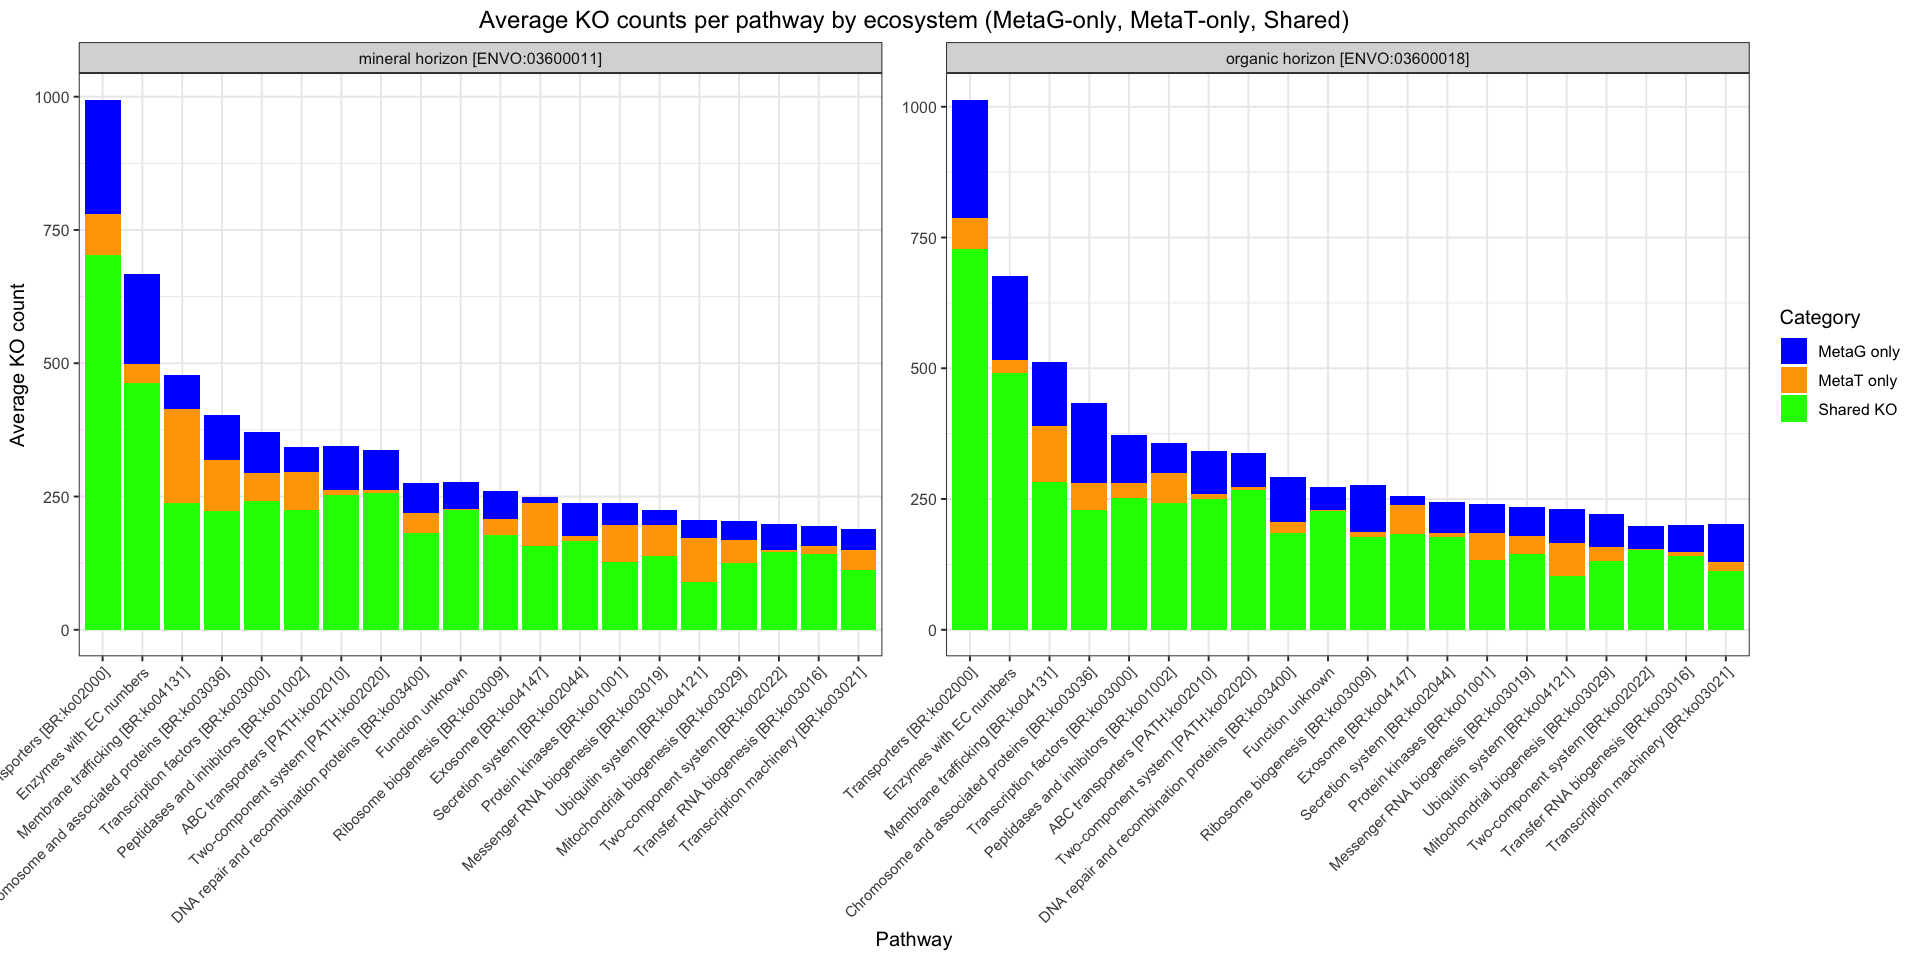

In [ ]:
## Now visualize pathway coverage across ecosystems by category

# -------- 1) Long format (mimics DataFrame.melt) --------
dfm <- eco_pathway %>%
  pivot_longer(
    cols = c(n_metag_only, n_metat_only, n_shared_kos),
    names_to = "category",
    values_to = "mean_count"
  )

# -------- 2) Top 20 pathways by total mean_count across ecosystems --------
top_paths <- dfm %>%
  group_by(pathway_name) %>%
  summarise(total = sum(mean_count, na.rm = TRUE), .groups = "drop") %>%
  arrange(desc(total)) %>%
  slice_head(n = 20) %>%
  pull(pathway_name)

dfm_top <- dfm %>%
  filter(pathway_name %in% top_paths) %>%
  mutate(
    # order pathways by the global total so facets share the same x-order
    pathway_name = factor(pathway_name, levels = top_paths),
    # match the color mapping from your Python code
    category = factor(
      category,
      levels = c("n_metag_only", "n_metat_only", "n_shared_kos"),
      labels = c("MetaG only", "MetaT only", "Shared KO")
    )
  )

# -------- 3) Colors (blue, orange, green) --------
cat_colors <- c("MetaG only" = "blue", "MetaT only" = "orange", "Shared KO" = "green")

# -------- 4) Plot (stacked bars, faceted by ecosystem) --------
p <- ggplot(dfm_top, aes(x = pathway_name, y = mean_count, fill = category)) +
  geom_col(position = "stack") +
  facet_wrap(~ env_local_scale, nrow = 1, scales = "free_y") +
  scale_fill_manual(values = cat_colors, name = "Category") +
  labs(
    title = "Average KO counts per pathway by ecosystem (MetaG-only, MetaT-only, Shared)",
    x = "Pathway",
    y = "Average KO count"
  ) +
  theme_bw(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 9),
    plot.title = element_text(hjust = 0.5),
    panel.spacing = unit(0.8, "lines")
  )

# -------- 5) Display --------
# Adjust plot size for better visibility in R notebooks
options(repr.plot.width = 16, repr.plot.height = 8)

print(p)

* Both ecosystems share a backbone of pathways dominated by shared KOs (green), especially in broad metabolic categories like **Transporters**, **Ribosome biogenesis**, **Membrane trafficking**.
* Mineral horizon seem to have relatively more MetaT-only KOs (orange), while Organic horizon show more MetaG-only KOs (blue) which is agreed with previous after breakdown to pathways.

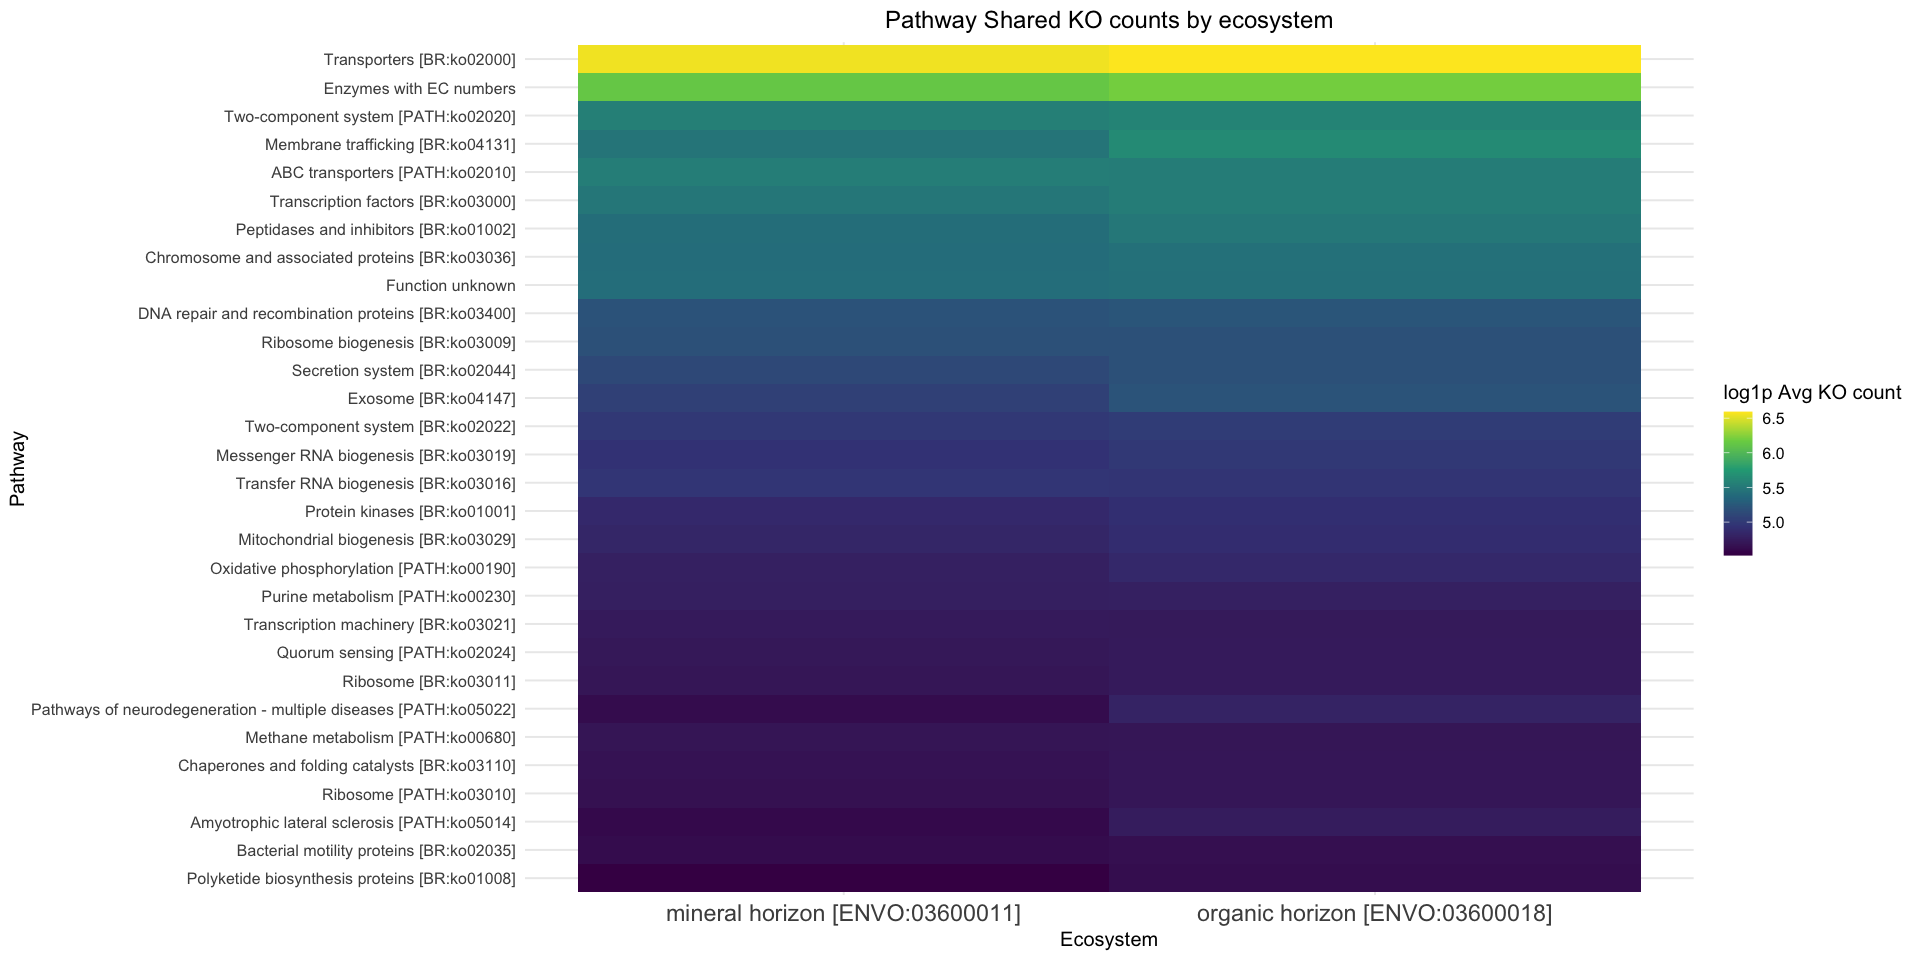

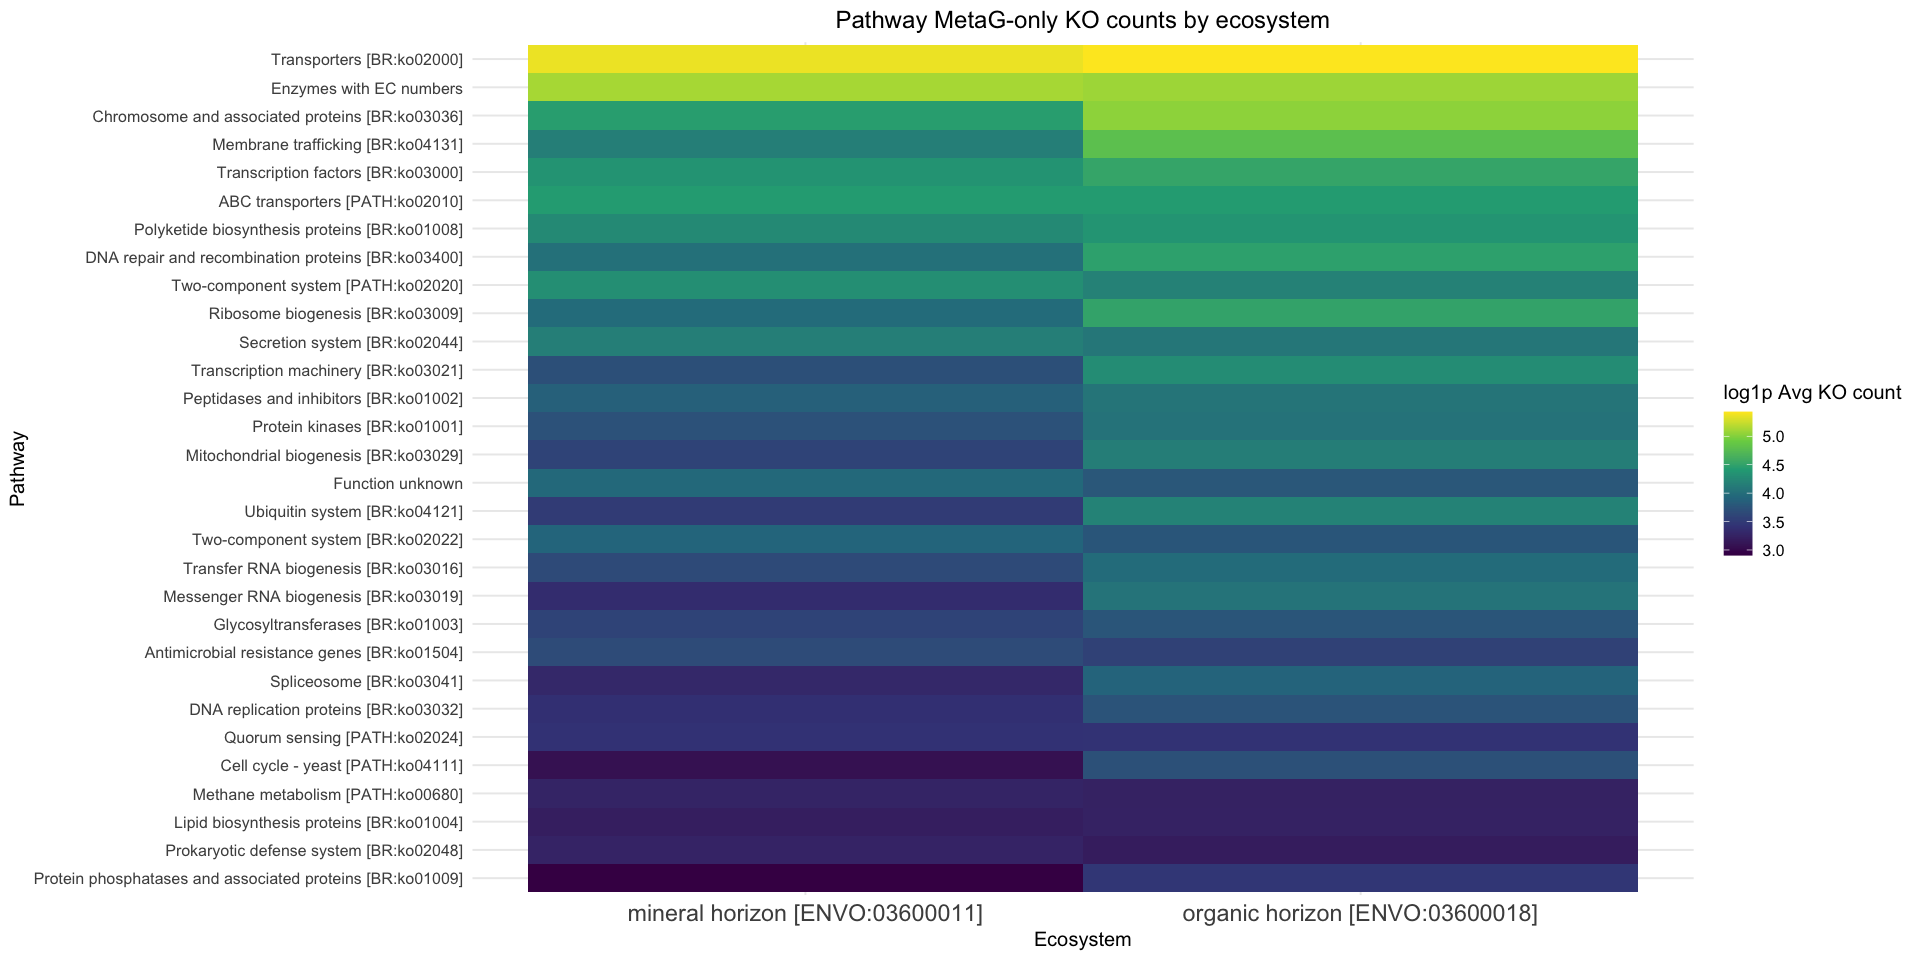

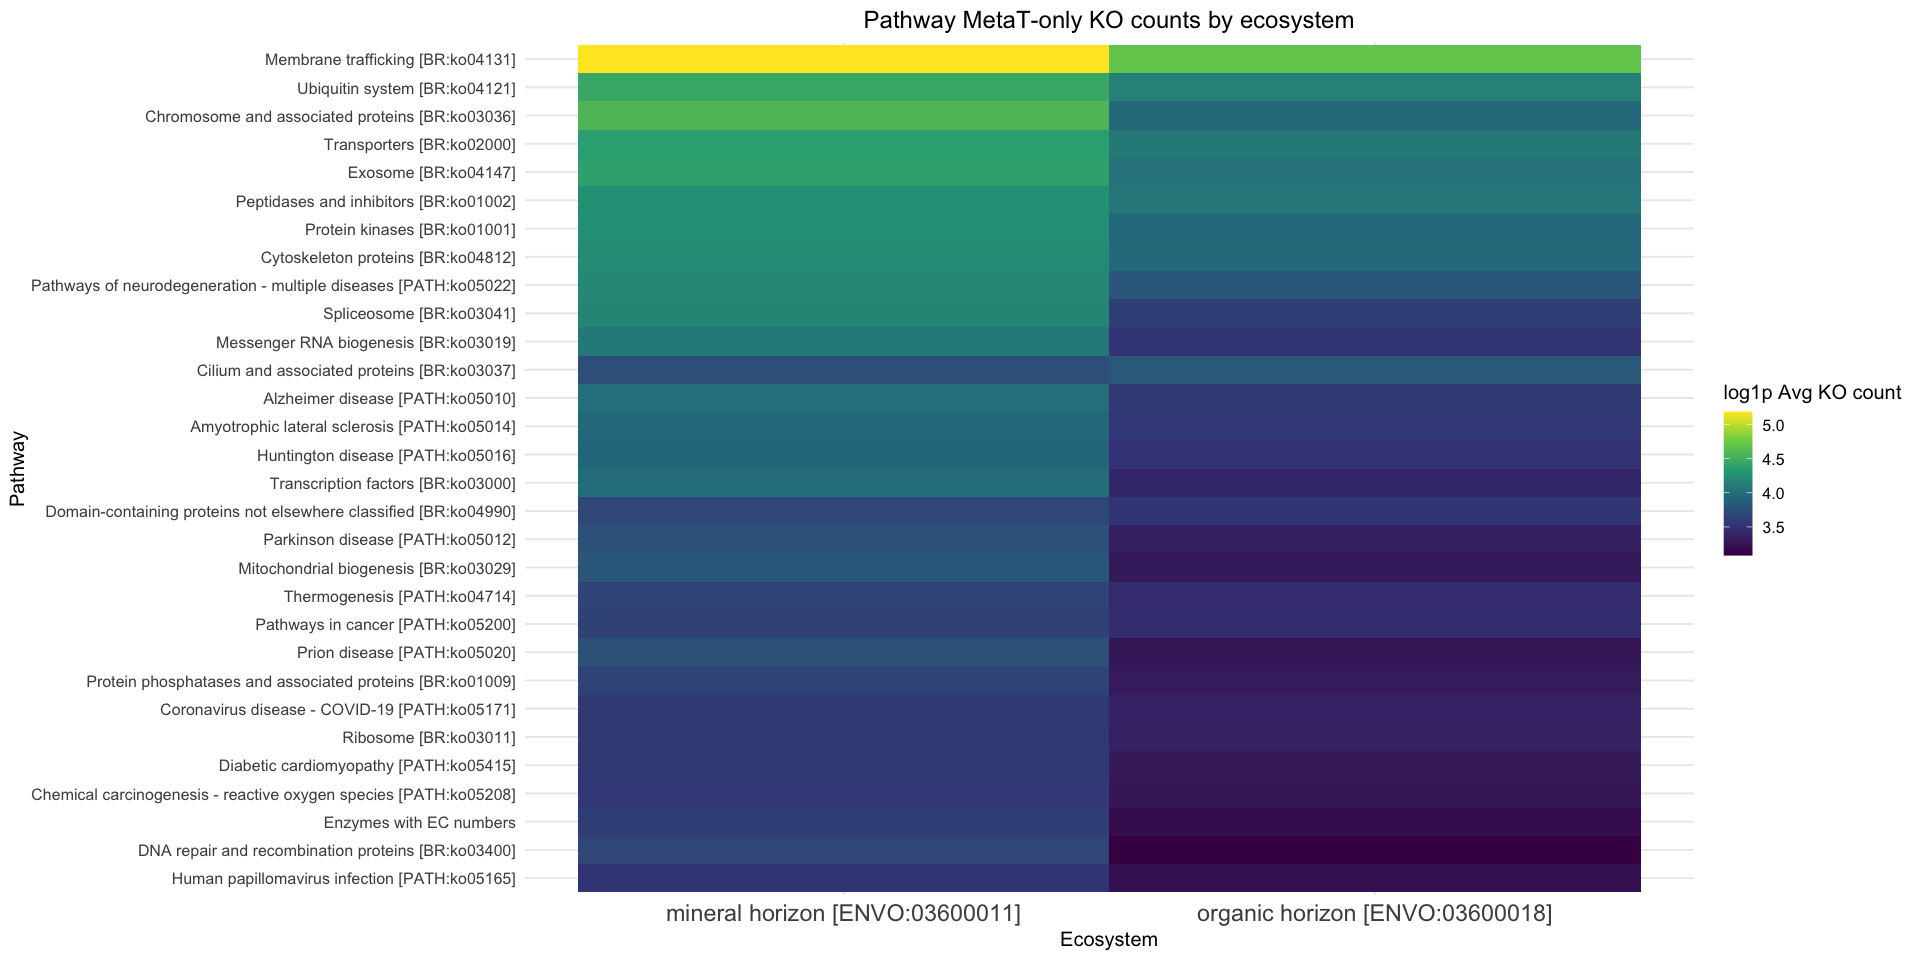

In [25]:
cat_labels <- c(
  "n_shared_kos" = "Shared KO counts",
  "n_metag_only" = "MetaG-only KO counts",
  "n_metat_only" = "MetaT-only KO counts"
)

for (cat in names(cat_labels)) {
  label <- cat_labels[[cat]]

  # 1) log1p transform of the chosen category
  df_log <- eco_pathway %>%
    mutate(log1p_cat = log1p(.data[[cat]])) %>%
    select(pathway_name, env_local_scale, log1p_cat)

  # 2) Make a wide matrix to compute totals and select top 30 pathways
  mat_wide <- df_log %>%
    tidyr::pivot_wider(
      names_from = env_local_scale,
      values_from = log1p_cat,
      values_fill = 0
    )

  # row sums across ecosystems -> order by total
  mat_ranked <- mat_wide %>%
    mutate(row_sum = rowSums(across(-pathway_name), na.rm = TRUE)) %>%
    arrange(desc(row_sum))

  top_paths <- head(mat_ranked$pathway_name, 30)

  # 3) Back to long for ggplot; order pathways by the computed ranking
  df_top <- df_log %>%
    filter(pathway_name %in% top_paths) %>%
    mutate(
      # reverse so the largest is at the top of the heatmap
      pathway_name = factor(pathway_name, levels = rev(top_paths))
    )

  if (nrow(df_top) == 0) {
    message("No data to plot for category: ", cat)
    next
  }

  # 4) Heatmap
  p <- ggplot(df_top, aes(x = env_local_scale, y = pathway_name, fill = log1p_cat)) +
    geom_tile() +
    labs(
      title = paste("Pathway", label, "by ecosystem"),
      x = "Ecosystem",
      y = "Pathway",
      fill = "log1p Avg KO count"
    ) +
    # Use a perceptually uniform scale if available; falls back to default if not
    suppressWarnings(scale_fill_viridis_c()) +
    theme_minimal(base_size = 12) +
    theme(
      axis.text.x = element_text(size = 14),
      plot.title  = element_text(hjust = 0.5)
    )
  # Show in-session
  print(p)
}

### Pathway shared KO counts by env_local_scale 
* Shared KOs represent the core functional repertoire that is both present and actively expressed in both ecosystems.
* Ecosystem differences are relatively modest here → core microbial metabolism is stable across soil horizons.

### Pathway MetaG-only KO counts by env_local_scale 
* Organic horizon contain a larger genomic reservoir of unexpressed functions — microbes may be carrying genes for future metabolic flexibility, but not currently expressing them.
* This aligns with the nutrient-rich nature of organic horizons, where microbial genomes may be more diverse but expression is tuned to immediate needs.

### Pathway MetaT-only KO counts by env_local_scale
* Mineral horizon contain more transcriptional activity from functions not well captured in metagenomic assemblies.



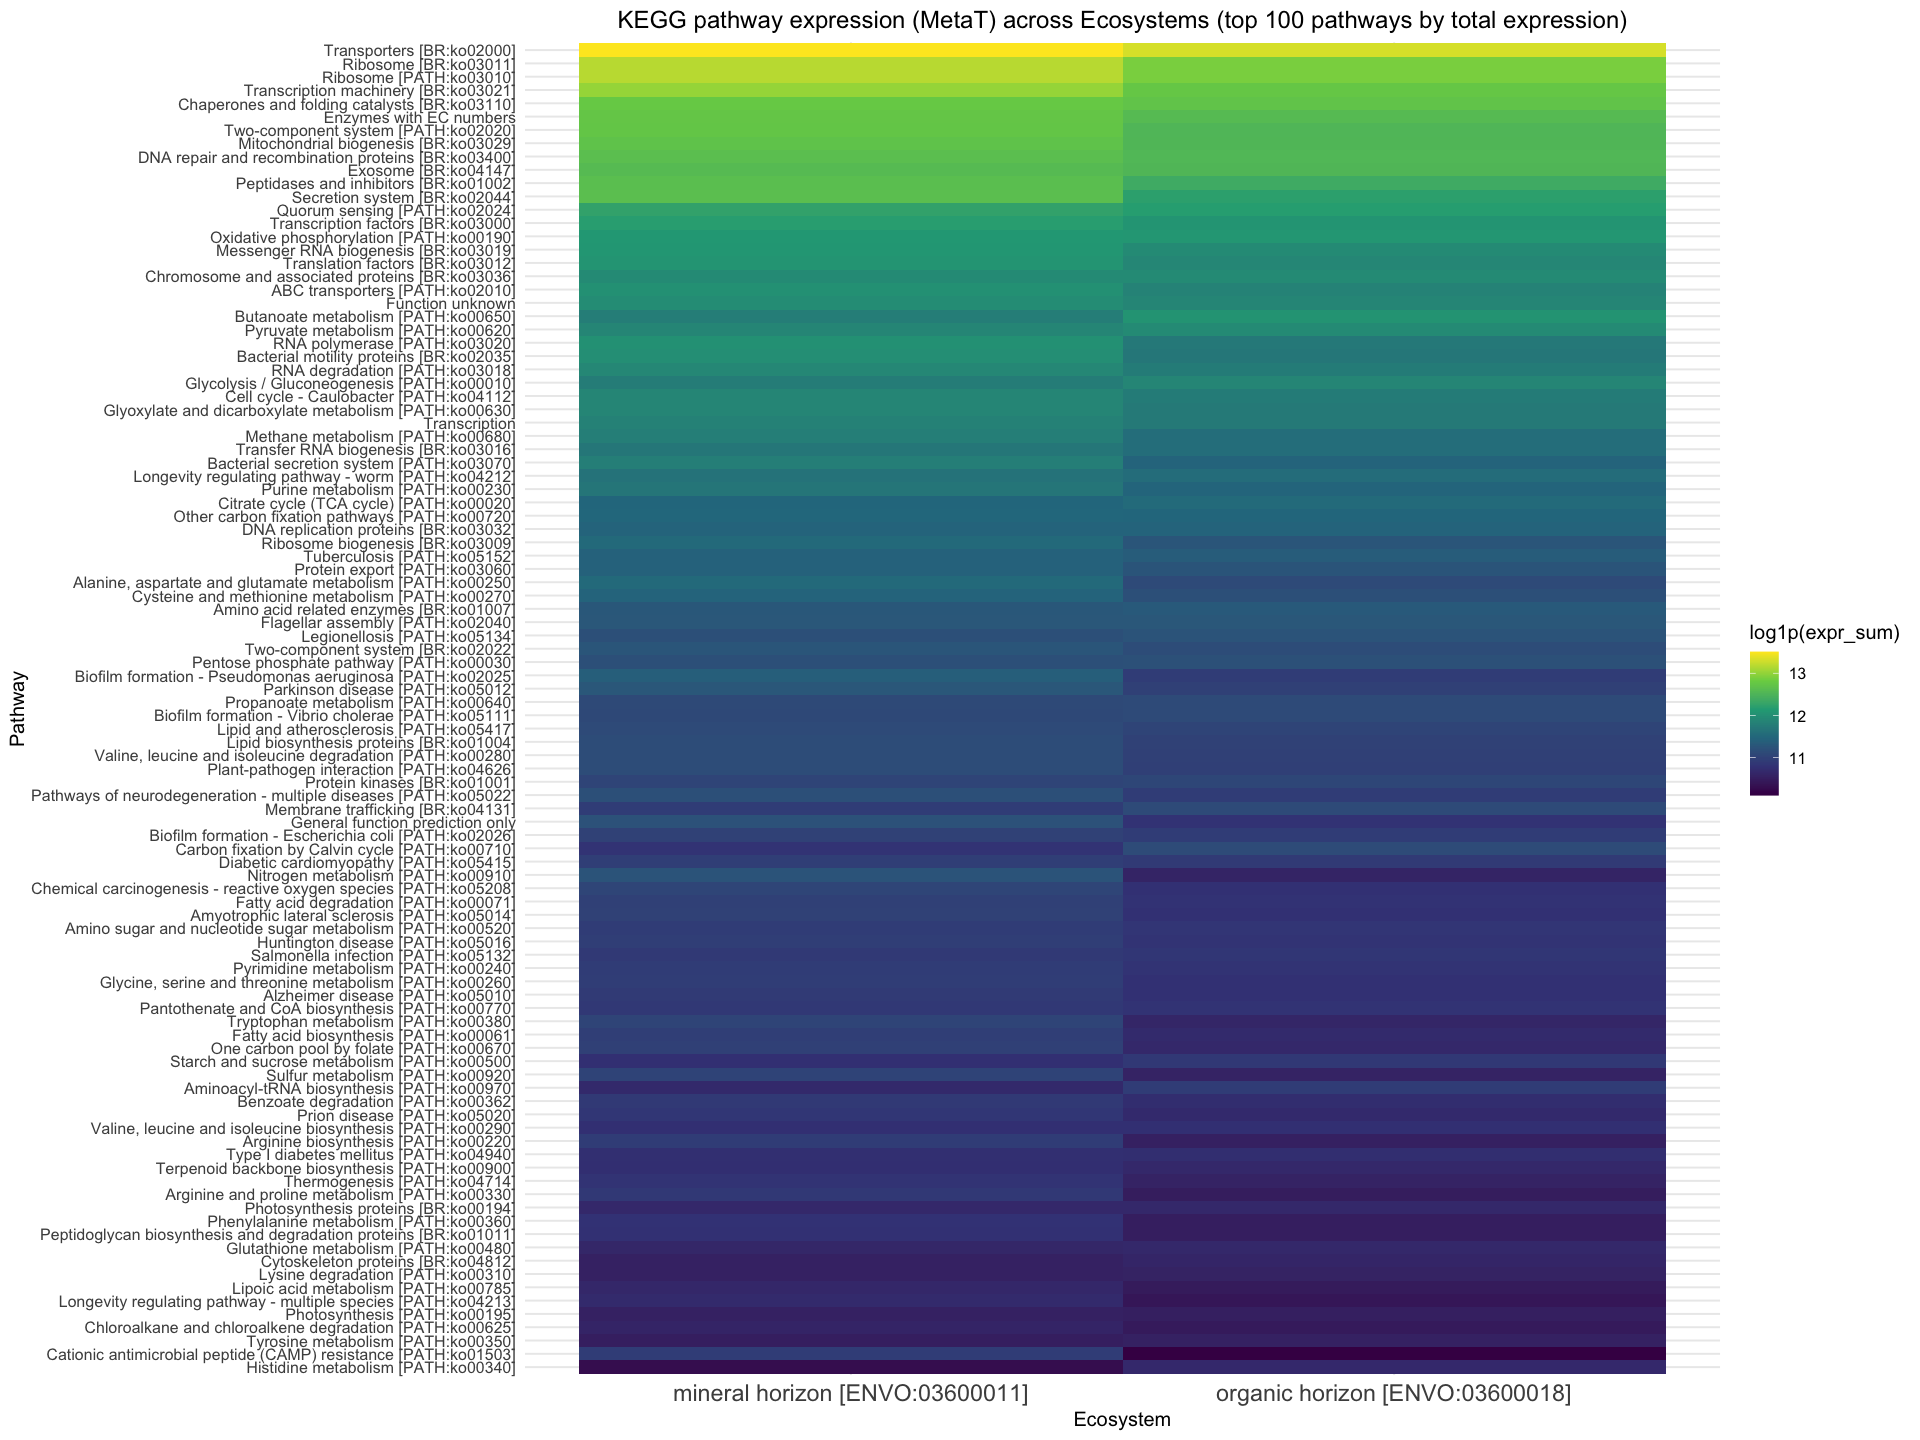

In [30]:
# Prefer existing CSV if it exists
f_expr <- file.path(OUTPUT_DIR, "pathway_expression_by_sample.csv")
if (file.exists(f_expr)) {
  pathway_expr <- readr::read_csv(f_expr, show_col_types = FALSE)
} else if (!exists("pathway_expr")) {
  stop("pathway_expression_by_sample.csv not found and object `pathway_expr` not in memory.")
}

# Check metadata
stopifnot(exists("biosample_metadata"))
stopifnot(all(c("biosample_id", "env_local_scale") %in% names(biosample_metadata)))

#$ Merge metadata -
pathway_expr_meta <- pathway_expr %>%
  left_join(
    biosample_metadata %>% select(biosample_id, env_local_scale),
    by = "biosample_id"
  )

#  Aggregate by ecosystem × pathway
eco_pathway_expr <- pathway_expr_meta %>%
  group_by(env_local_scale, pathway_name, pathway_id) %>%
  summarise(expr_sum = mean(expr_sum, na.rm = TRUE), .groups = "drop")

# ---- Nothing to plot? ----
if (!exists("pathway_expr") || nrow(pathway_expr) == 0) {
  message("No pathway_expr data available; nothing to plot.")
} else {
  # 1) log1p transform
  mat <- eco_pathway_expr %>%
    mutate(log_expr = log1p(as.numeric(expr_sum))) %>%
    select(pathway_name, env_local_scale, log_expr)

  # 2) Pivot to wide to compute totals and rank pathways
  heat_wide <- mat %>%
    tidyr::pivot_wider(
    names_from  = env_local_scale,
    values_from = log_expr,
    values_fn   = list(log_expr = ~ mean(.x, na.rm = TRUE)),   # <-- aggregator
    values_fill = list(log_expr = 0)                            # <-- named list
  )


  # Sum across ecosystems; order desc; take top 100
  heat_ranked <- heat_wide %>%
    mutate(total = rowSums(across(-pathway_name), na.rm = TRUE)) %>%
    arrange(desc(total))

  top_paths <- head(heat_ranked$pathway_name, 100)

  # 3) Back to long for ggplot; order pathways so biggest totals at top
  heat_long <- mat %>%
    filter(pathway_name %in% top_paths) %>%
    mutate(
      # keep the ranked order; reverse for top at the top of the plot
      pathway_name = factor(pathway_name, levels = rev(top_paths))
    )

  # 4) Heatmap
  p <- ggplot(heat_long, aes(x = env_local_scale, y = pathway_name, fill = log_expr)) +
    geom_tile() +
    labs(
      title = "KEGG pathway expression (MetaT) across Ecosystems (top 100 pathways by total expression)",
      x = "Ecosystem",
      y = "Pathway",
      fill = "log1p(expr_sum)"
    ) +
    suppressWarnings(scale_fill_viridis_c()) +
    theme_minimal(base_size = 12) +
    theme(
      axis.text.x = element_text(size = 14),
      plot.title  = element_text(hjust = 0.5)
    )
    # Adjust plot size for better visibility in R notebooks
  options(repr.plot.width = 16, repr.plot.height = 12)
  print(p)
}

* The highest-expressed pathways across both mineral and organic horizon are Transporters, Ribosome, Chaperones & folding catalysts, Two-component systems, DNA repair/recombination, and Peptidases.
* Expression intensity patterns look broadly similar between mineral and organic horizon, with only subtle differences in magnitude.
* The similarity between ecosystems suggests a conserved core of functional activity despite environmental differences — basic cellular and stress-response processes are strongly expressed everywhere.


In [37]:
# ---- Function: Kruskal–Wallis per pathway ----
kruskal_wallis_across_samples <- function(pathway_expr) {
  if (is.null(pathway_expr) || nrow(pathway_expr) == 0) {
    return(tibble(
      pathway_id = character(),
      pathway_name = character(),
      p_value = numeric(),
      q_value = numeric(),
      n_samples = integer()
    ))
  }

  # Group by pathway and test across biosamples
  results <- pathway_expr %>%
    group_by(pathway_id, pathway_name) %>%
    summarise(
      n_samples = n_distinct(biosample_id[!is.na(expr_sum)]),
      p_value = {
        if (n_samples >= 2) {
          # Kruskal–Wallis across biosamples for this pathway
          tryCatch(stats::kruskal.test(expr_sum ~ biosample_id, data = cur_data())$p.value,
                   error = function(e) NA_real_)
        } else {
          NA_real_
        }
      },
      .groups = "drop"
    ) %>%
    arrange(p_value)

  # Multiple testing correction (similar to BH)
  if (sum(!is.na(results$p_value)) > 0) {
    results <- results %>%
      arrange(p_value) %>%
      mutate(
        rank = rank(p_value, ties.method = "first"),
        m    = sum(!is.na(p_value)),
        q_value = pmin(1, p_value * m / rank)
      ) %>%
      select(-rank, -m)
  } else {
    results$q_value <- NA_real_
  }

  results %>%
    arrange(q_value)
}

# ---- Run and save ----
kw_df <- kruskal_wallis_across_samples(pathway_expr)

# Preview
print(head(kw_df, 20))

# A tibble: 20 × 5
   pathway_id pathway_name                             n_samples p_value q_value
   <chr>      <chr>                                        <int>   <dbl>   <dbl>
 1 map04913   Ovarian steroidogenesis [PATH:ko04913]          24   0.461   0.461
 2 map00563   Glycosylphosphatidylinositol (GPI)-anch…        24   0.461   0.462
 3 map00535   Proteoglycans [BR:ko00535]                      24   0.461   0.462
 4 map99983   Lipid metabolism                                24   0.461   0.463
 5 map05340   Primary immunodeficiency [PATH:ko05340]         24   0.461   0.464
 6 map05221   Acute myeloid leukemia [PATH:ko05221]           24   0.461   0.465
 7 map05217   Basal cell carcinoma [PATH:ko05217]             24   0.461   0.466
 8 map05150   Staphylococcus aureus infection [PATH:k…        24   0.461   0.467
 9 map04977   Vitamin digestion and absorption [PATH:…        24   0.461   0.468
10 map04933   AGE-RAGE signaling pathway in diabetic …        24   0.461   0.469
11 map047

* There is no significant difference in the number KO expression value of metatranscriptomes across the biosamples analyzed (Kruskal-Wallis p > 0.05).

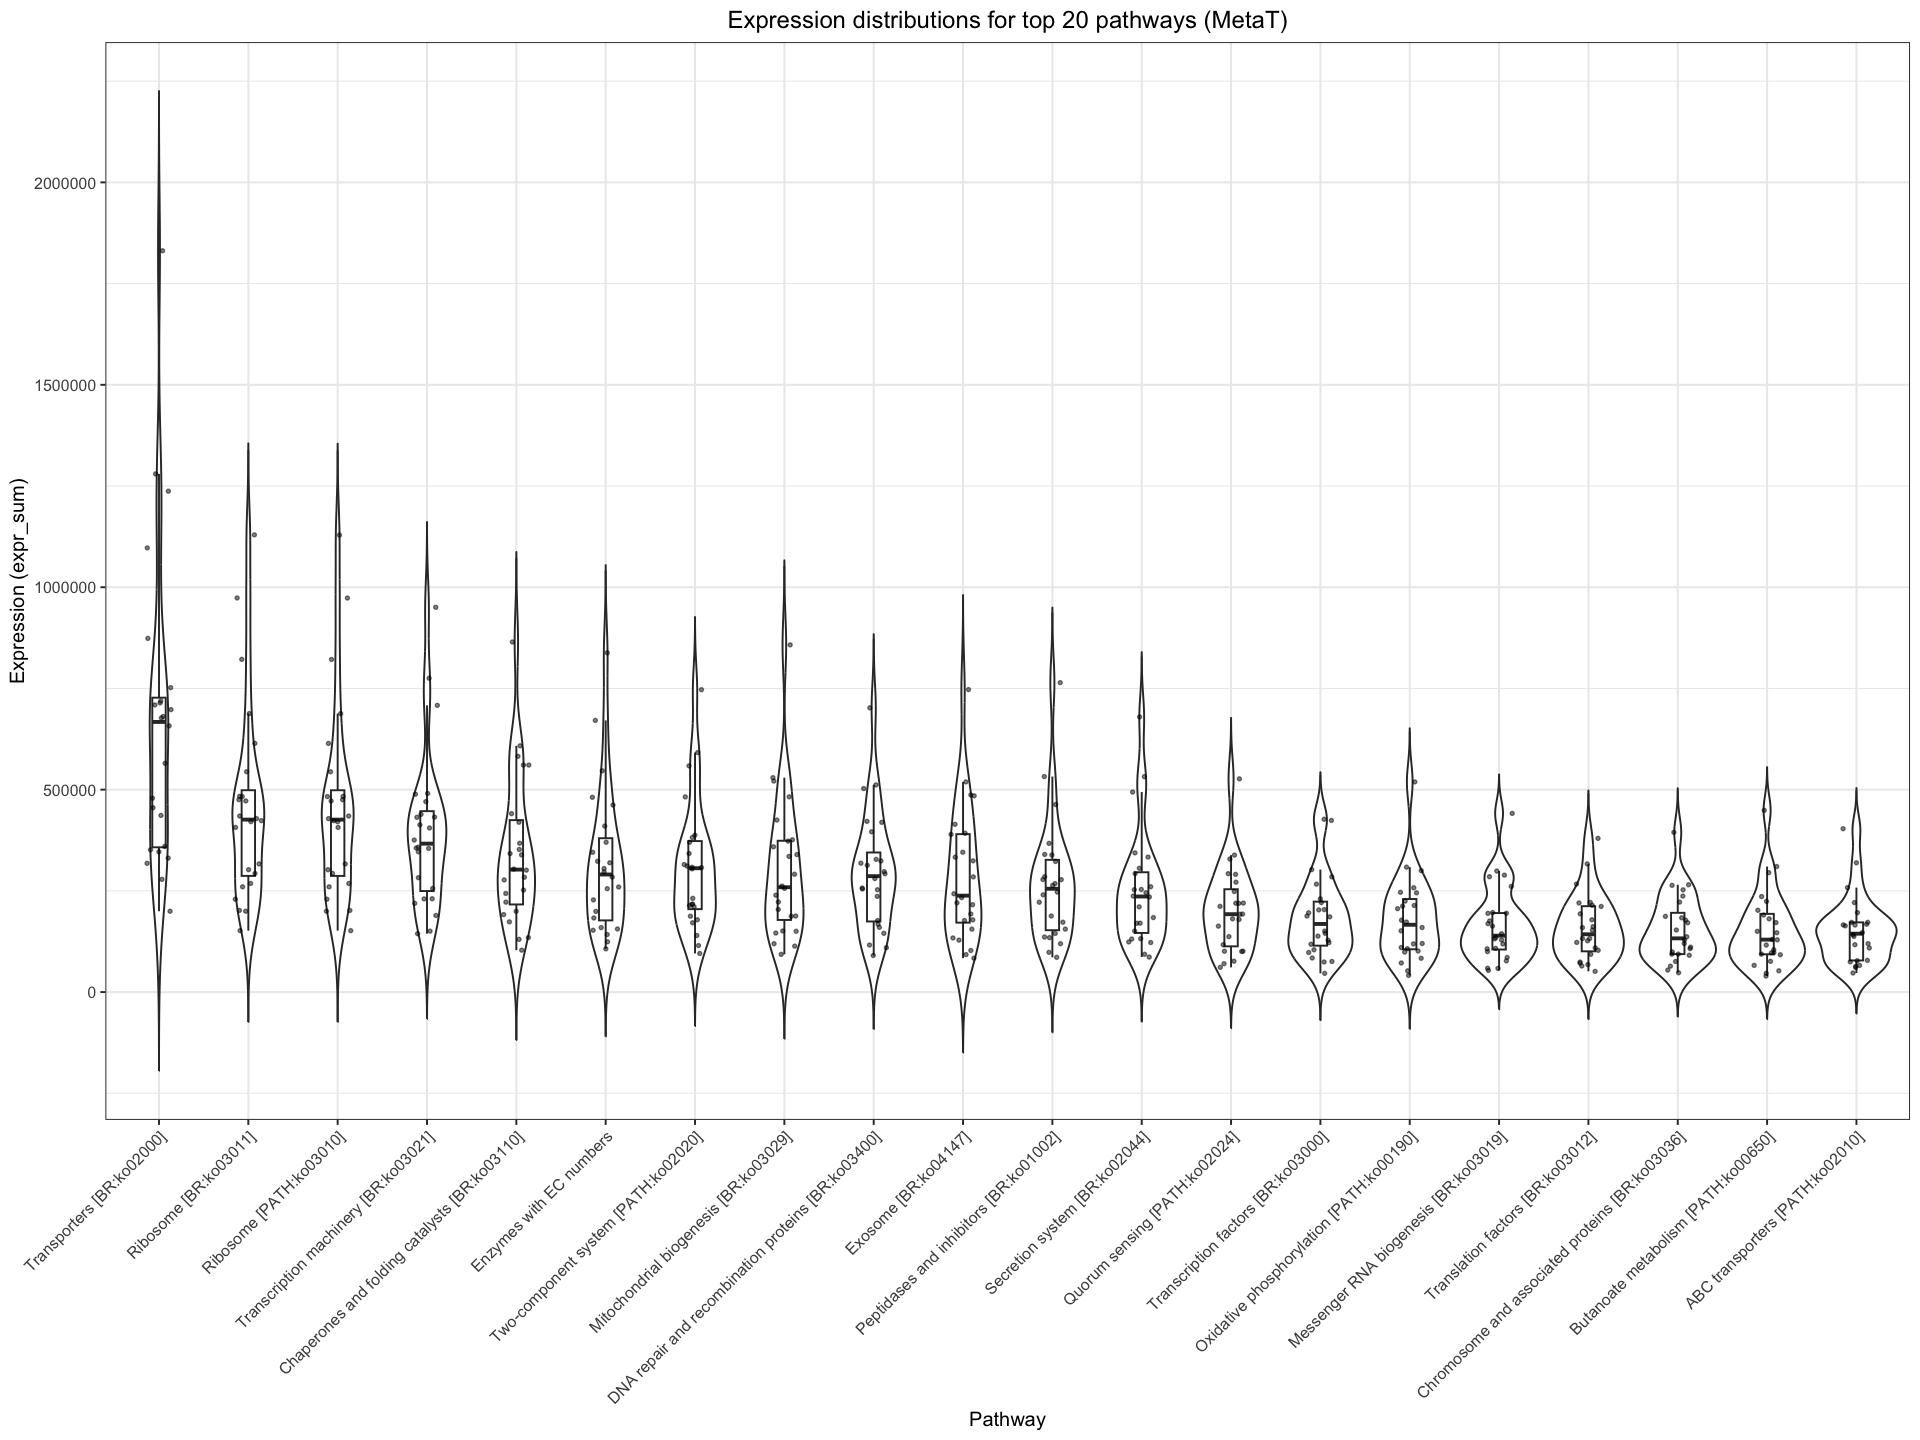

In [39]:
if (nrow(pathway_expr) > 0) {
  # ensure numeric
  pathway_expr <- mutate(pathway_expr, expr_sum = as.numeric(expr_sum))

  # ---- Rank pathways by total expression; keep top 20 ----
  ranks <- pathway_expr %>%
    group_by(pathway_id, pathway_name) %>%
    summarise(total_expr = sum(expr_sum, na.rm = TRUE), .groups = "drop") %>%
    arrange(desc(total_expr)) %>%
    slice_head(n = 20)

  top_ids <- ranks$pathway_id

  sub <- pathway_expr %>%
    filter(pathway_id %in% top_ids) %>%
    # order x-axis by the ranking
    mutate(
      pathway_name = factor(
        pathway_name,
        levels = ranks$pathway_name  # already ordered by total_expr desc
      )
    )

  # ---- Violin + box + points (like px.violin(..., box=True, points="all")) ----
  p <- ggplot(sub, aes(x = pathway_name, y = expr_sum)) +
    geom_violin(trim = FALSE) +
    geom_boxplot(width = 0.15, outlier.shape = NA) +
    geom_jitter(width = 0.15, alpha = 0.5, size = 0.8) +
    labs(
      title = "Expression distributions for top 20 pathways (MetaT)",
      x = "Pathway",
      y = "Expression (expr_sum)"
    ) +
    theme_bw(base_size = 12) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      plot.title  = element_text(hjust = 0.5)
    )

  print(p)
}

* Expression is highly skewed: a few pathways (e.g., Transporters, Ribosome, Transcription machinery) show very wide distributions, with some biosamples having extremely high expression.
* Other pathways (e.g., DNA repair, Chaperones, Exosome) show more compact distributions, suggesting consistent expression across biosamples.
* Expression variability is highest in pathways linked to environmental interactions (e.g., transporters, sensing systems), suggesting these are key levers of ecological adaptation in soils.

## 4. Taxonomy comparison: MetaG lineage vs MetaT lineage + expression

Here we perform similar analysis to the KO annoation above. We parses lineage TSVs, splits lineage into ranks (kingdom→species).
* Aggregates:
  * MetaG: gene counts per taxon (e.g., genus).
  * MetaT: expression summed per taxon (by joining MetaT lineage to MetaT expression).
* Computes Spearman correlation between MetaG counts and MetaT expression across taxa per biosample.
* Bidirectional barchart for kindom and phylum level:
  *	MetaG gene counts (log1p) heatmap
  * MetaT expression (log1p) heatmap

In [ ]:
# ============================================================
# 1) Parse lineage table from a lineage URL
#    (on-demand using load_lineage_table)
# ============================================================
parse_lineage_from_url <- function(lineage_url) {
  df_lin <- load_lineage_table(lineage_url)  # <- your cached/retry loader
  rank_cols <- c("kingdom","phylum","class","order","family","genus","species")

  if (is.null(df_lin) || nrow(df_lin) == 0) {
    return(tibble(
      gene_id = character(), lineage = character(),
      !!!setNames(rep(list(character()), 7), rank_cols)
    ))
  }

  if (!all(c("gene_id","lineage") %in% names(df_lin))) {
    stop("Lineage file missing gene_id or lineage column.")
  }

  # Split lineage into up to 7 levels (semicolon or pipe)
  split_list <- str_split(df_lin$lineage, pattern = "[;|]\\s*")
  padded <- lapply(split_list, function(parts) {
    parts <- parts[!is.na(parts) & nzchar(parts)]
    out <- rep(NA_character_, 7)
    n <- min(length(parts), 7L)
    if (n > 0) out[seq_len(n)] <- trimws(parts[seq_len(n)])
    out
  })

  rank_df <- as_tibble(do.call(rbind, padded), .name_repair = "minimal")
  names(rank_df) <- rank_cols

  tibble(
    gene_id = as.character(df_lin$gene_id),
    lineage = df_lin$lineage
  ) %>%
    bind_cols(rank_df)
}

# ============================================================
# 2) Taxonomy vs expression per biosample (on-demand)
#    datastore_index must include:
#    biosample_id, metag_lineage_url, metat_lineage_url, metat_expr_url
# ============================================================
taxonomy_vs_expression_on_demand <- function(datastore_index, rank = "genus") {
  if (nrow(datastore_index) == 0) {
    empty_mg <- tibble(biosample_id = character(), taxon = character(), count = integer())
    empty_mt <- tibble(biosample_id = character(), taxon = character(), expr_sum = numeric())
    empty_st <- tibble(biosample_id = character(), spearman_r = numeric(), p_value = numeric(), n_taxa = integer())
    return(list(metaG_counts = empty_mg, metaT_expr = empty_mt, spearman = empty_st))
  }

  mg_rows <- list()
  mt_rows <- list()
  st_rows <- list()

  for (i in seq_len(nrow(datastore_index))) {
    biosample_id    <- datastore_index$biosample_id[i]
    metag_line_url  <- datastore_index$metag_lineage_url[i]
    metat_line_url  <- datastore_index$metat_lineage_url[i]
    metat_expr_url  <- datastore_index$metat_expr_url[i]

    # ---- On-demand loaders ----
    mg_lin <- parse_lineage_from_url(metag_line_url)
    mt_lin <- parse_lineage_from_url(metat_line_url)
    expr   <- parse_expression_from_url(metat_expr_url)  # defined earlier

    if (!(rank %in% names(mg_lin)) || !(rank %in% names(mt_lin))) next

    # ---- MetaG: unique gene counts per taxon ----
    if (nrow(mg_lin) > 0) {
      mg_counts <- mg_lin %>%
        filter(!is.na(.data[[rank]]), nzchar(.data[[rank]])) %>%
        group_by(.data[[rank]]) %>%
        summarise(count = n_distinct(gene_id), .groups = "drop") %>%
        transmute(biosample_id = biosample_id, taxon = .data[[rank]], count = as.integer(count))
      if (nrow(mg_counts)) mg_rows[[length(mg_rows) + 1L]] <- mg_counts
    }

    # ---- MetaT: sum expression per taxon ----
    if (nrow(mt_lin) > 0 && nrow(expr) > 0) {
      mt_join <- mt_lin %>% left_join(expr, by = "gene_id")
      mt_sum <- mt_join %>%
        filter(!is.na(.data[[rank]]), nzchar(.data[[rank]])) %>%
        group_by(.data[[rank]]) %>%
        summarise(expr_sum = sum(expr_value, na.rm = TRUE), .groups = "drop") %>%
        transmute(biosample_id = biosample_id, taxon = .data[[rank]], expr_sum = as.numeric(expr_sum))
      if (nrow(mt_sum)) mt_rows[[length(mt_rows) + 1L]] <- mt_sum
    }

    # ---- Correlation across taxa ----
    if (nrow(mg_lin) > 0 && nrow(mt_lin) > 0 && nrow(expr) > 0) {
      mgc <- mg_lin %>%
        filter(!is.na(.data[[rank]]), nzchar(.data[[rank]])) %>%
        group_by(.data[[rank]]) %>%
        summarise(count = n_distinct(gene_id), .groups = "drop")

      mtj <- mt_lin %>% left_join(expr, by = "gene_id")
      mts <- mtj %>%
        filter(!is.na(.data[[rank]]), nzchar(.data[[rank]])) %>%
        group_by(.data[[rank]]) %>%
        summarise(expr_sum = sum(expr_value, na.rm = TRUE), .groups = "drop")

      both <- mgc %>%
        inner_join(mts, by = setNames(rank, rank)) %>%
        rename(taxon = !!rank)

      if (nrow(both) >= 3) {
        ct <- tryCatch(cor.test(both$count, both$expr_sum, method = "spearman"), error = function(e) NULL)
        if (!is.null(ct)) {
          st_rows[[length(st_rows) + 1L]] <- tibble(
            biosample_id = biosample_id,
            spearman_r = unname(ct$estimate),
            p_value    = ct$p.value,
            n_taxa     = nrow(both)
          )
        } else {
          st_rows[[length(st_rows) + 1L]] <- tibble(
            biosample_id = biosample_id,
            spearman_r = NA_real_, p_value = NA_real_, n_taxa = nrow(both)
          )
        }
      } else {
        st_rows[[length(st_rows) + 1L]] <- tibble(
          biosample_id = biosample_id,
          spearman_r = NA_real_, p_value = NA_real_, n_taxa = nrow(both)
        )
      }
    }
  }

  mg_df <- if (length(mg_rows)) bind_rows(mg_rows) else tibble(biosample_id = character(), taxon = character(), count = integer())
  mt_df <- if (length(mt_rows)) bind_rows(mt_rows) else tibble(biosample_id = character(), taxon = character(), expr_sum = numeric())
  st_df <- if (length(st_rows)) bind_rows(st_rows) else tibble(biosample_id = character(), spearman_r = numeric(), p_value = numeric(), n_taxa = integer())

  # write CSVs
  readr::write_csv(mg_df, file.path(OUTPUT_DIR, paste0("taxonomy_metaG_counts_", rank, ".csv")))
  readr::write_csv(mt_df, file.path(OUTPUT_DIR, paste0("taxonomy_metaT_expr_", rank, ".csv")))
  readr::write_csv(st_df, file.path(OUTPUT_DIR, paste0("taxonomy_spearman_", rank, ".csv")))

  list(metaG_counts = mg_df, metaT_expr = mt_df, spearman = st_df)
}

# ---------- 3) Example runs ----------
res_kingdom <- taxonomy_vs_expression_on_demand(datastore_index, rank = "kingdom")
metaG_counts_kingdom <- res_kingdom$metaG_counts
metaT_expr_kingdom   <- res_kingdom$metaT_expr
tax_corr_kingdom     <- res_kingdom$spearman
head(metaG_counts_kingdom, 10)
head(metaT_expr_kingdom, 10)
head(tax_corr_kingdom, 10)

res_phylum <- taxonomy_vs_expression_on_demand(datastore_index, rank = "phylum")
metaG_counts_phylum <- res_phylum$metaG_counts
metaT_expr_phylum   <- res_phylum$metaT_expr
tax_corr_phylum     <- res_phylum$spearman
head(metaG_counts_phylum, 10)
head(metaT_expr_phylum, 10)
head(tax_corr_phylum, 10)

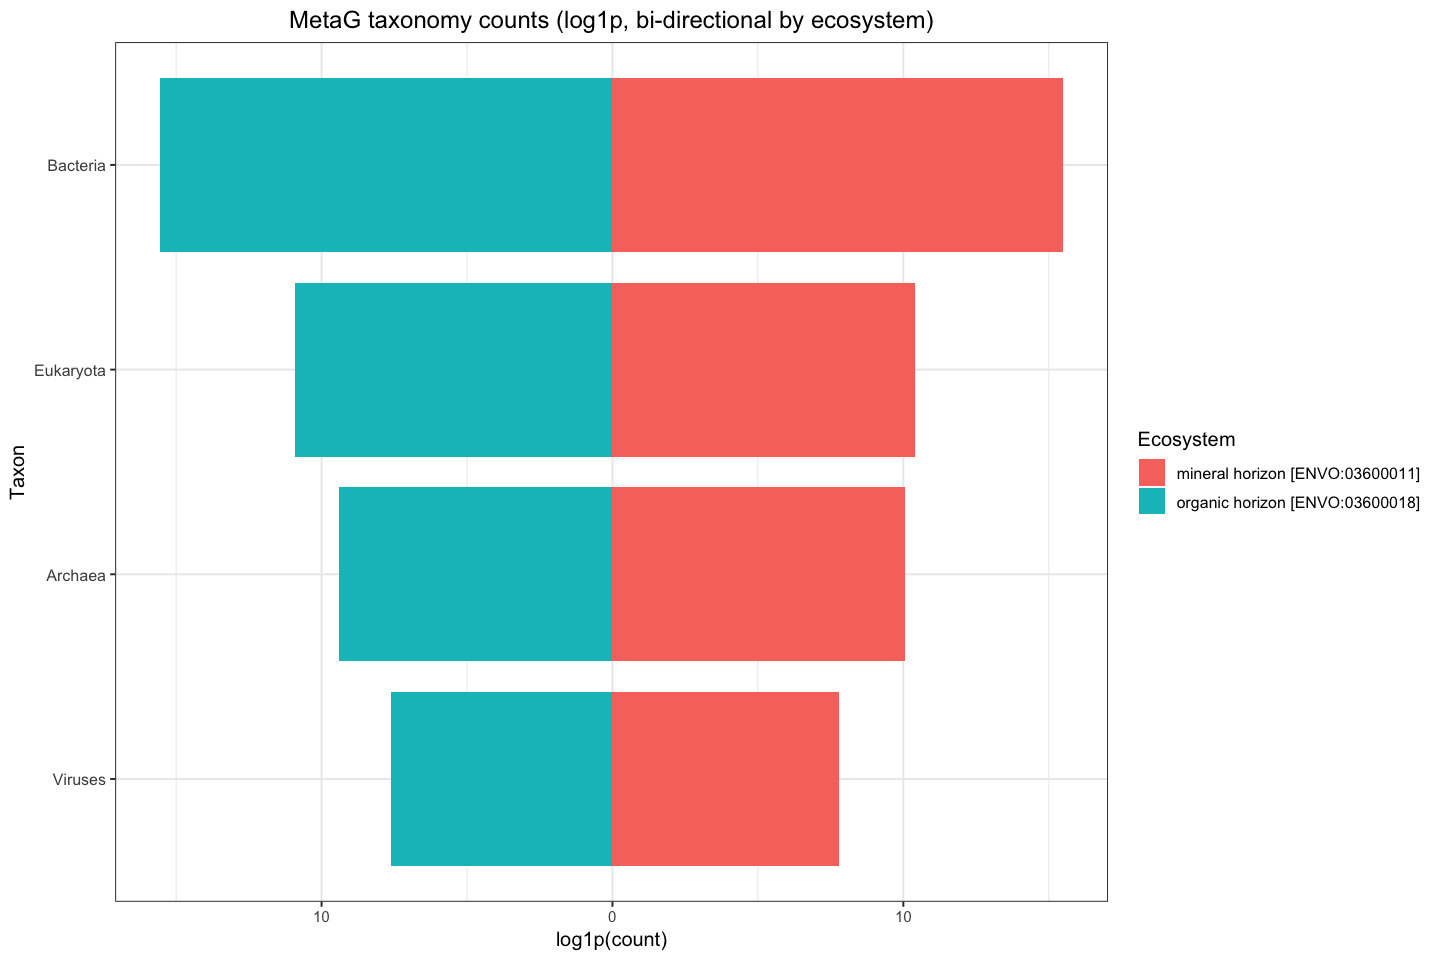

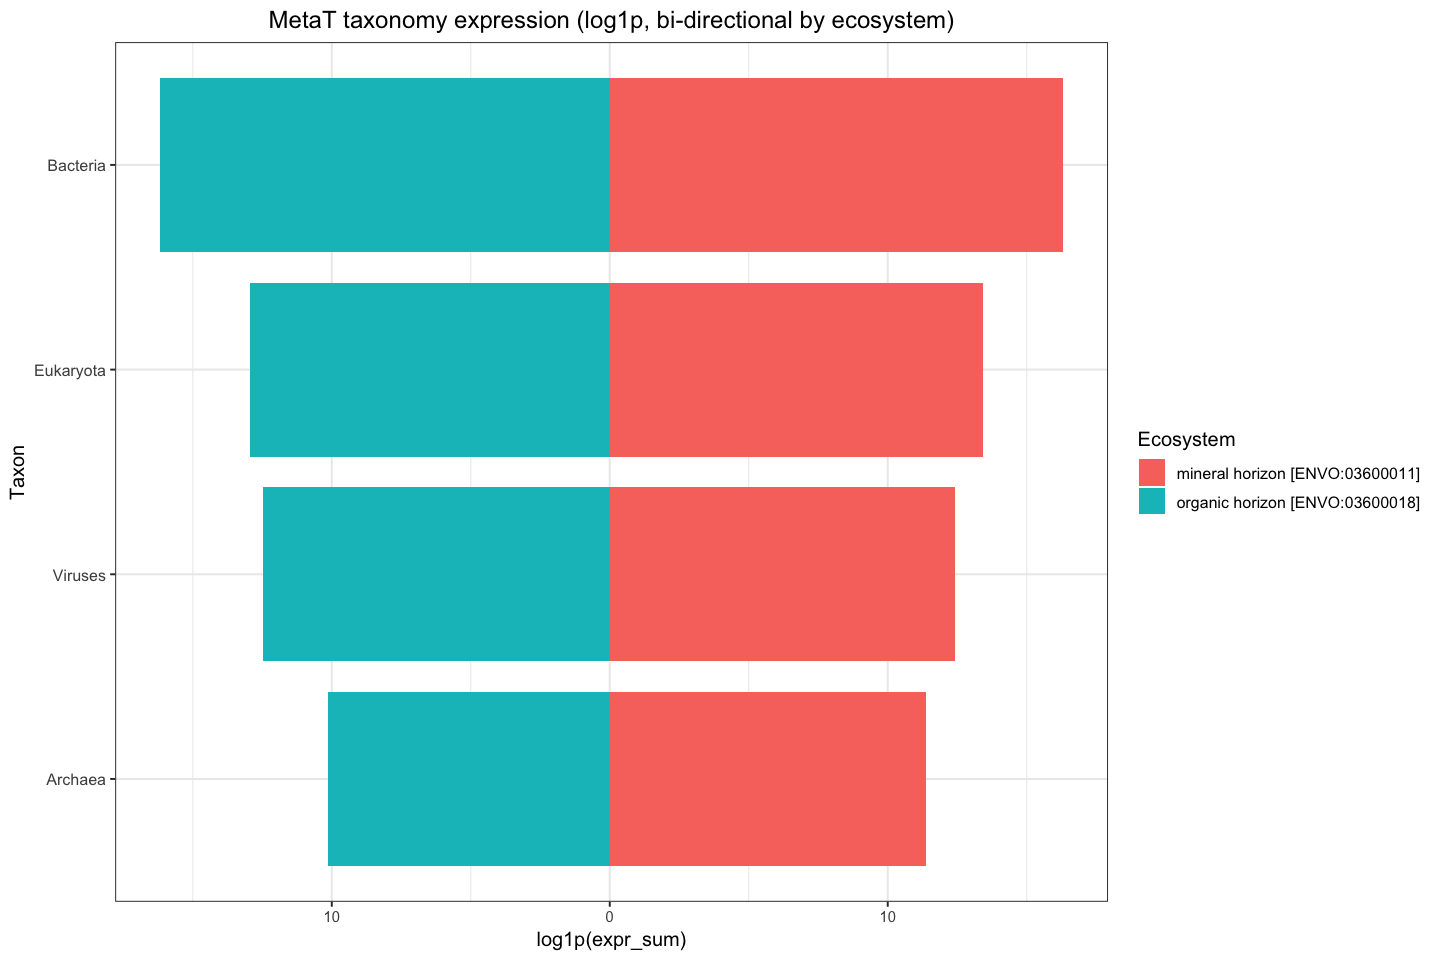

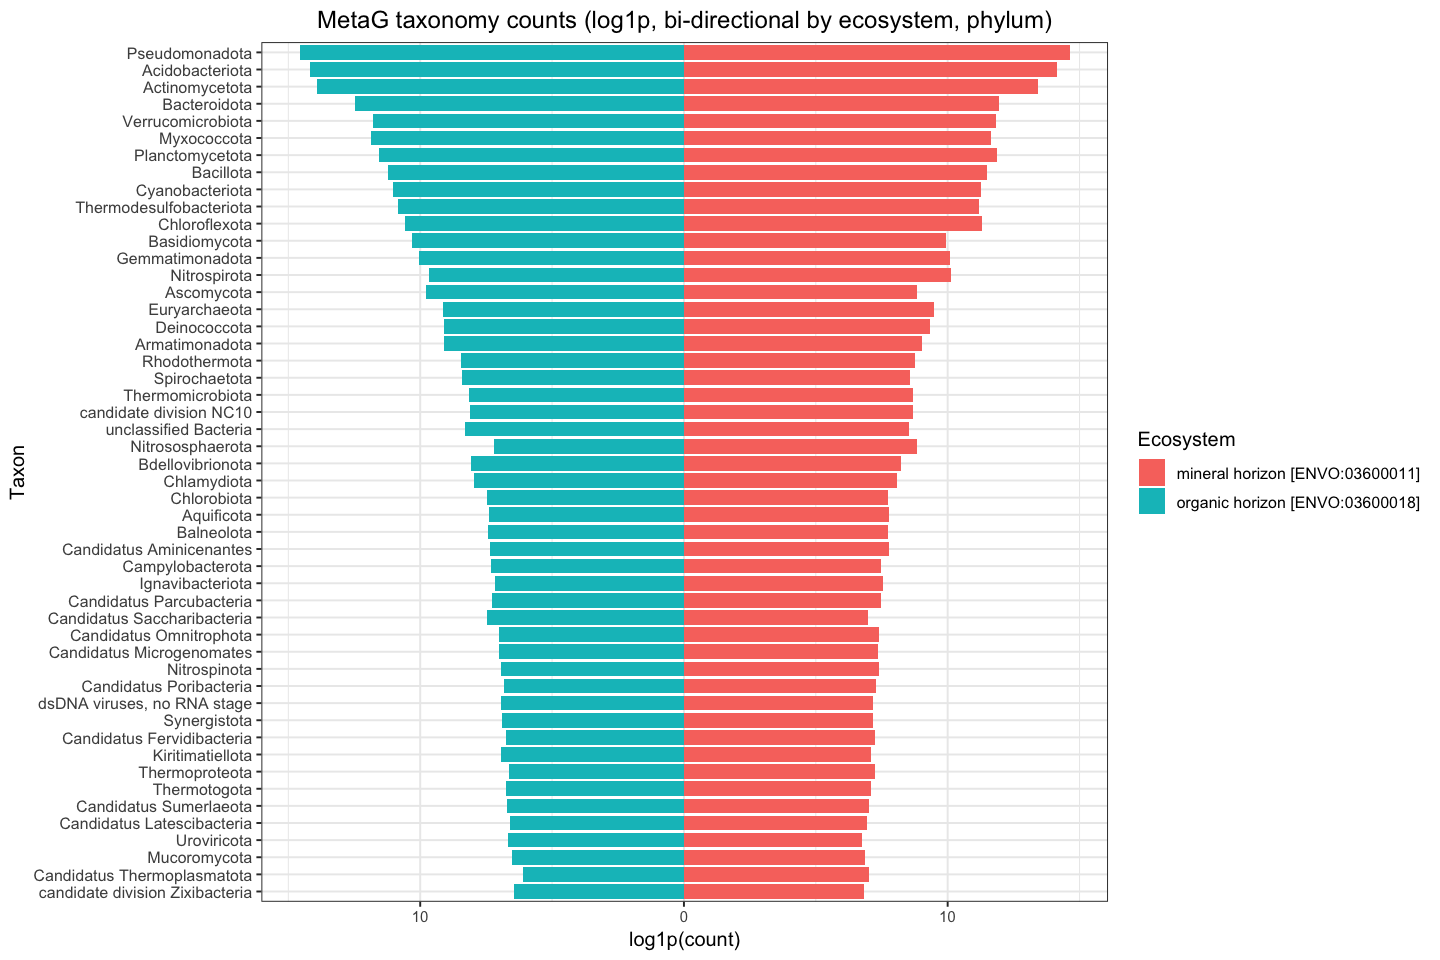

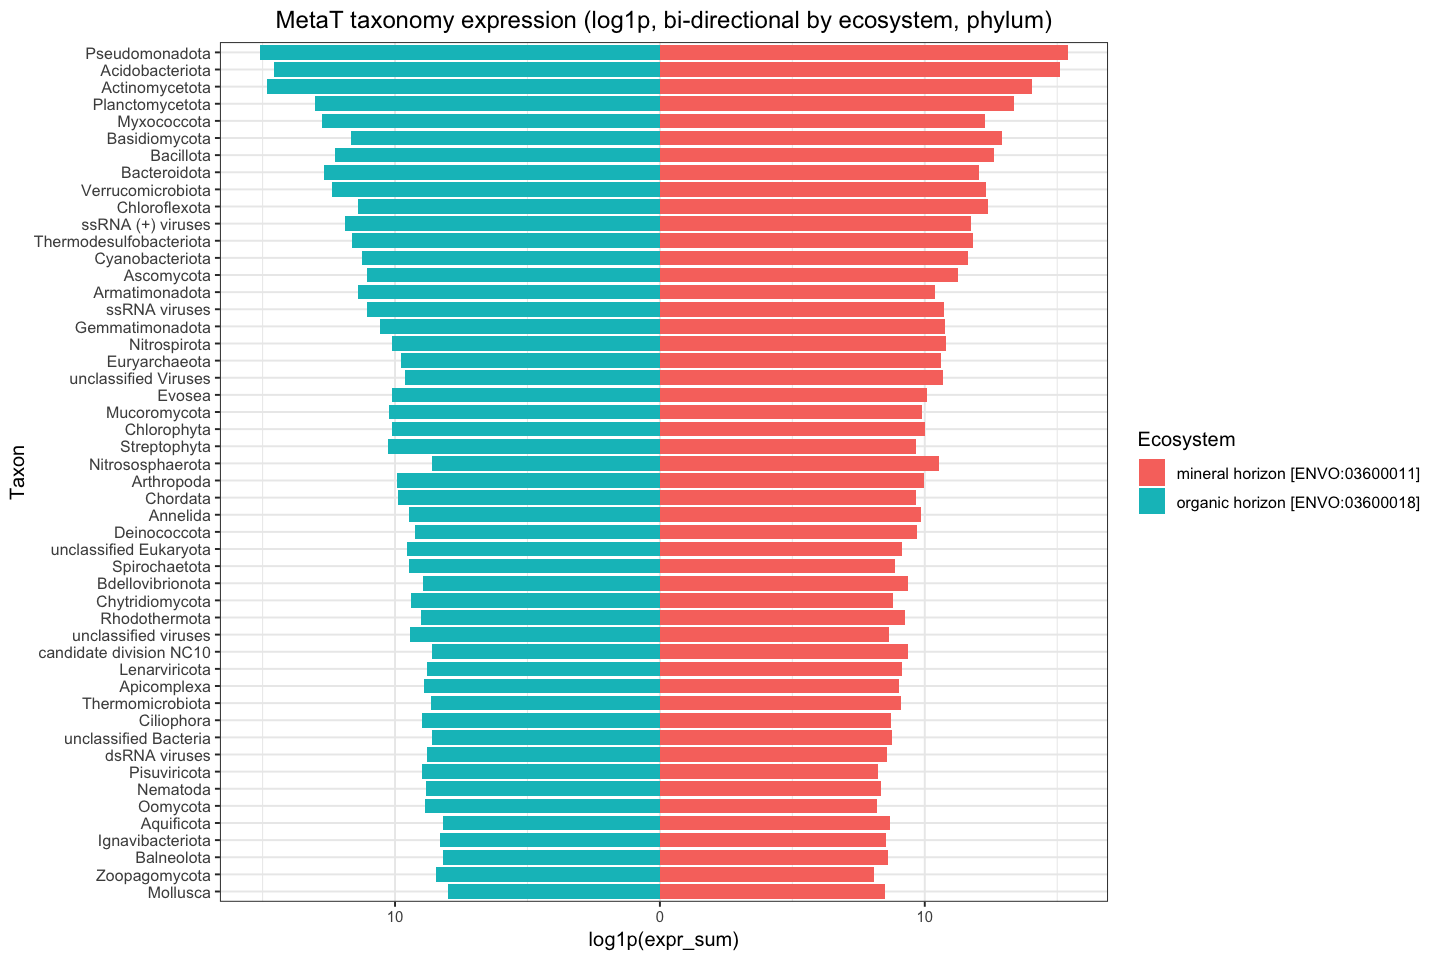

In [47]:
options(repr.plot.width = 12, repr.plot.height = 8)

f_mg_king  <- file.path(OUTPUT_DIR, "taxonomy_metaG_counts_kingdom.csv")
f_mt_king  <- file.path(OUTPUT_DIR, "taxonomy_metaT_expr_kingdom.csv")
f_mg_phyl  <- file.path(OUTPUT_DIR, "taxonomy_metaG_counts_phylum.csv")
f_mt_phyl  <- file.path(OUTPUT_DIR, "taxonomy_metaT_expr_phylum.csv")

# ---------- Load inputs if files exist ----------
if (file.exists(f_mg_king))  metaG_counts_kingdom <- readr::read_csv(f_mg_king, show_col_types = FALSE)
if (file.exists(f_mt_king))  metaT_expr_kingdom   <- readr::read_csv(f_mt_king, show_col_types = FALSE)
if (file.exists(f_mg_phyl))  metaG_counts_phylum  <- readr::read_csv(f_mg_phyl, show_col_types = FALSE)
if (file.exists(f_mt_phyl))  metaT_expr_phylum    <- readr::read_csv(f_mt_phyl, show_col_types = FALSE)


#-----------------------------#
# Helper: bi-directional plot #
#-----------------------------#
# df must have: env_local_scale, taxon, <value_col>
bidir_barplot_gg <- function(df, value_col, title, top_n = 20,
                             png_file = NULL, pdf_file = NULL) {

  stopifnot(all(c("env_local_scale", "taxon", value_col) %in% names(df)))

  # Top taxa by global SUM (before any transforms)
  top_taxa <- df %>%
    group_by(taxon) %>%
    summarise(total = sum(.data[[value_col]], na.rm = TRUE), .groups = "drop") %>%
    arrange(desc(total)) %>%
    slice_head(n = top_n) %>%
    pull(taxon)

  sub <- df %>%
    filter(taxon %in% top_taxa) %>%
    mutate(taxon = factor(taxon, levels = rev(top_taxa)))  # show top at top after coord_flip

  ecos <- unique(na.omit(sub$env_local_scale))
  if (length(ecos) != 2) {
    message("[INFO] Found ", length(ecos), " ecosystems (need 2 for bi-directional). Making grouped bars.")

    p <- sub %>%
      mutate(value = .data[[value_col]]) %>%
      ggplot(aes(x = taxon, y = value, fill = env_local_scale)) +
      geom_col(position = position_dodge(width = 0.8)) +
      coord_flip() +
      labs(title = title, x = "Taxon", y = value_col, fill = "Ecosystem") +
      theme_bw(base_size = 12) +
      theme(axis.text.x = element_text(size = 9),
            plot.title = element_text(hjust = 0.5))
  } else {
    eco1 <- ecos[1]; eco2 <- ecos[2]

    # Mirror one ecosystem negative; then log1p with sign
    sub2 <- sub %>%
      mutate(value_raw = .data[[value_col]],
             value_signed = if_else(env_local_scale == eco2, -value_raw, value_raw),
             value_log1p  = sign(value_signed) * log1p(abs(value_signed)))

    # Positive values stack above 0, negative below 0 (relative-like)
    p <- ggplot(sub2, aes(x = taxon, y = value_log1p, fill = env_local_scale)) +
      geom_col(position = "stack", width = 0.85) +
      coord_flip() +
      scale_y_continuous(labels = function(x) abs(x)) +
      labs(
        title = title,
        x = "Taxon",
        y = paste0("log1p(", value_col, ")"),
        fill = "Ecosystem"
      ) +
      theme_bw(base_size = 12) +
      theme(
        axis.text.x = element_text(size = 9),
        plot.title  = element_text(hjust = 0.5),
        panel.spacing = unit(0.8, "lines")
      )
  }

  # Save if paths provided
  if (!is.null(png_file)) ggsave(file.path(OUTPUT_DIR, png_file), plot = p, width = 10, height = 6, dpi = 300)
  if (!is.null(pdf_file)) ggsave(file.path(OUTPUT_DIR, pdf_file), plot = p, width = 10, height = 6)

  return(p)
}

#-------------------------------------------#
# KINGDOM level — MetaG counts (mean by eco) #
#-------------------------------------------#
metaG_counts_meta <- metaG_counts_kingdom %>%
  left_join(biosample_metadata %>% select(biosample_id, env_local_scale), by = "biosample_id")

agg_mg_kingdom <- metaG_counts_meta %>%
  group_by(env_local_scale, taxon) %>%
  summarise(count = mean(count, na.rm = TRUE), .groups = "drop")

p_mg_kingdom <- bidir_barplot_gg(
  agg_mg_kingdom, value_col = "count",
  title = "MetaG taxonomy counts (log1p, bi-directional by ecosystem)",
  top_n = 20,
  png_file = "bidir_barchart_metaG_kingdom_counts.png",
  pdf_file = "bidir_barchart_metaG_kingdom_counts.pdf"
)
print(p_mg_kingdom)

#---------------------------------------------#
# KINGDOM level — MetaT expression (mean eco) #
#---------------------------------------------#
metaT_expr_meta <- metaT_expr_kingdom %>%
  left_join(biosample_metadata %>% select(biosample_id, env_local_scale), by = "biosample_id")

agg_mt_kingdom <- metaT_expr_meta %>%
  group_by(env_local_scale, taxon) %>%
  summarise(expr_sum = mean(expr_sum, na.rm = TRUE), .groups = "drop")

p_mt_kingdom <- bidir_barplot_gg(
  agg_mt_kingdom, value_col = "expr_sum",
  title = "MetaT taxonomy expression (log1p, bi-directional by ecosystem)",
  top_n = 20,
  png_file = "bidir_barchart_metaT_kingdom_expression.png",
  pdf_file = "bidir_barchart_metaT_kingdom_expression.pdf"
)
print(p_mt_kingdom)

#------------------------------------------#
# PHYLUM level — MetaG counts (mean by eco)#
#------------------------------------------#
metaG_counts_meta_ph <- metaG_counts_phylum %>%
  left_join(biosample_metadata %>% select(biosample_id, env_local_scale), by = "biosample_id")

agg_mg_phylum <- metaG_counts_meta_ph %>%
  group_by(env_local_scale, taxon) %>%
  summarise(count = mean(count, na.rm = TRUE), .groups = "drop")

p_mg_phylum <- bidir_barplot_gg(
  agg_mg_phylum, value_col = "count",
  title = "MetaG taxonomy counts (log1p, bi-directional by ecosystem, phylum)",
  top_n = 50,
  png_file = "bidir_barchart_metaG_phylum_counts.png",
  pdf_file = "bidir_barchart_metaG_phylum_counts.pdf"
)
print(p_mg_phylum)

#--------------------------------------------#
# PHYLUM level — MetaT expression (mean eco) #
#--------------------------------------------#
metaT_expr_meta_ph <- metaT_expr_phylum %>%
  left_join(biosample_metadata %>% select(biosample_id, env_local_scale), by = "biosample_id")

agg_mt_phylum <- metaT_expr_meta_ph %>%
  group_by(env_local_scale, taxon) %>%
  summarise(expr_sum = mean(expr_sum, na.rm = TRUE), .groups = "drop")

p_mt_phylum <- bidir_barplot_gg(
  agg_mt_phylum, value_col = "expr_sum",
  title = "MetaT taxonomy expression (log1p, bi-directional by ecosystem, phylum)",
  top_n = 50,
  png_file = "bidir_barchart_metaT_phylum_expression.png",
  pdf_file = "bidir_barchart_metaT_phylum_expression.pdf"
)
print(p_mt_phylum)

### Kingdom level
* Both ecosystems are dominated by Bacteria, followed by smaller contributions from Archaea, Eukaryota, and Viruses.

### Phylum level
* Organic horizon: more transcriptional contribution from fungi (Ascomycota, Basidiomycota) and viruses, suggesting richer multi-kingdom interactions.

### Taxonomy Overlap Analysis

For each biosample and each taxonomic rank (e.g. kingdom, phylum, class, order, family, genus, species):
1. Parse MetaG lineage → get the set of taxa names at that rank.
2. Parse MetaT lineage → get the set of taxa names at that rank.
3. Compute:
	* n_metag_taxa = number of taxa found in MetaG at this rank
	* n_metat_taxa = number of taxa found in MetaT at this rank
	* n_shared_taxa = size of intersection
	* n_metag_only = MetaG-only taxa
	* n_metat_only = MetaT-only taxa
	* jaccard = |shared| / |union|
4. Store results in a long table
5. Visualizations:
	* Group bar (shared vs unique taxa) across ecosystme × rank
	* Heatmap (shared taxa counts or Jaccard) across biosample and box plot accross ecosystme × ranks

In [ ]:
# Where to save
out_path <- file.path(OUTPUT_DIR, "taxonomy_overlap_summary.csv")

# --- Helper: parse lineage from URL (uses your load_lineage_table) ---
parse_lineage_from_url <- function(lineage_url) {
  df_lin <- load_lineage_table(lineage_url)
  rank_cols <- c("kingdom","phylum","class","order","family","genus","species")

  if (is.null(df_lin) || nrow(df_lin) == 0) {
    return(tibble(gene_id = character(), lineage = character(),
                  !!!setNames(rep(list(character()), 7), rank_cols)))
  }
  if (!all(c("gene_id","lineage") %in% names(df_lin))) {
    stop("Lineage file missing gene_id or lineage column.")
  }

  split_list <- stringr::str_split(df_lin$lineage, pattern = "[;|]\\s*")
  padded <- lapply(split_list, function(parts) {
    parts <- parts[!is.na(parts) & nzchar(parts)]
    out <- rep(NA_character_, 7)
    n <- min(length(parts), 7L)
    if (n > 0) out[seq_len(n)] <- trimws(parts[seq_len(n)])
    out
  })
  rank_df <- as_tibble(do.call(rbind, padded))
  names(rank_df) <- rank_cols

  tibble(
    gene_id = as.character(df_lin$gene_id),
    lineage = df_lin$lineage
  ) %>% bind_cols(rank_df)
}

# --- On-demand taxonomy overlap ---
# datastore_index must have: biosample_id, metag_lineage_url, metat_lineage_url
taxonomy_overlap_stats_on_demand <- function(datastore_index, ranks = NULL) {
  if (is.null(ranks)) {
    ranks <- c("kingdom","phylum","class","order","family","genus","species")
  }
  if (!all(c("biosample_id","metag_lineage_url","metat_lineage_url") %in% names(datastore_index))) {
    stop("datastore_index must contain biosample_id, metag_lineage_url, metat_lineage_url")
  }

  rows <- vector("list", nrow(datastore_index))
  j <- 1L

  for (i in seq_len(nrow(datastore_index))) {
    biosample_id   <- as.character(datastore_index$biosample_id[i])
    metag_line_url <- datastore_index$metag_lineage_url[i]
    metat_line_url <- datastore_index$metat_lineage_url[i]

    mg_lin <- parse_lineage_from_url(metag_line_url)
    mt_lin <- parse_lineage_from_url(metat_line_url)

    if (nrow(mg_lin) == 0 && nrow(mt_lin) == 0) next

    for (rank in ranks) {
      if (!(rank %in% names(mg_lin)) || !(rank %in% names(mt_lin))) next

      mg_set <- unique(na.omit(mg_lin[[rank]]))
      mt_set <- unique(na.omit(mt_lin[[rank]]))
      shared <- intersect(mg_set, mt_set)
      uni    <- union(mg_set, mt_set)
      jacc   <- if (length(uni) > 0) length(shared) / length(uni) else NA_real_

      rows[[j]] <- tibble(
        biosample_id  = biosample_id,
        rank          = rank,
        n_metag_taxa  = length(mg_set),
        n_metat_taxa  = length(mt_set),
        n_shared_taxa = length(shared),
        n_metag_only  = length(setdiff(mg_set, mt_set)),
        n_metat_only  = length(setdiff(mt_set, mg_set)),
        jaccard       = jacc
      )
      j <- j + 1L
    }
  }

  if (j > 1L) bind_rows(rows[seq_len(j - 1L)]) else
    tibble(
      biosample_id  = character(),
      rank          = character(),
      n_metag_taxa  = integer(),
      n_metat_taxa  = integer(),
      n_shared_taxa = integer(),
      n_metag_only  = integer(),
      n_metat_only  = integer(),
      jaccard       = numeric()
    )
}

# ---- Run & Save ----
tax_overlap_df <- taxonomy_overlap_stats_on_demand(datastore_index)
readr::write_csv(tax_overlap_df, out_path)

# ---- Preview ----
print(head(tax_overlap_df, 20))

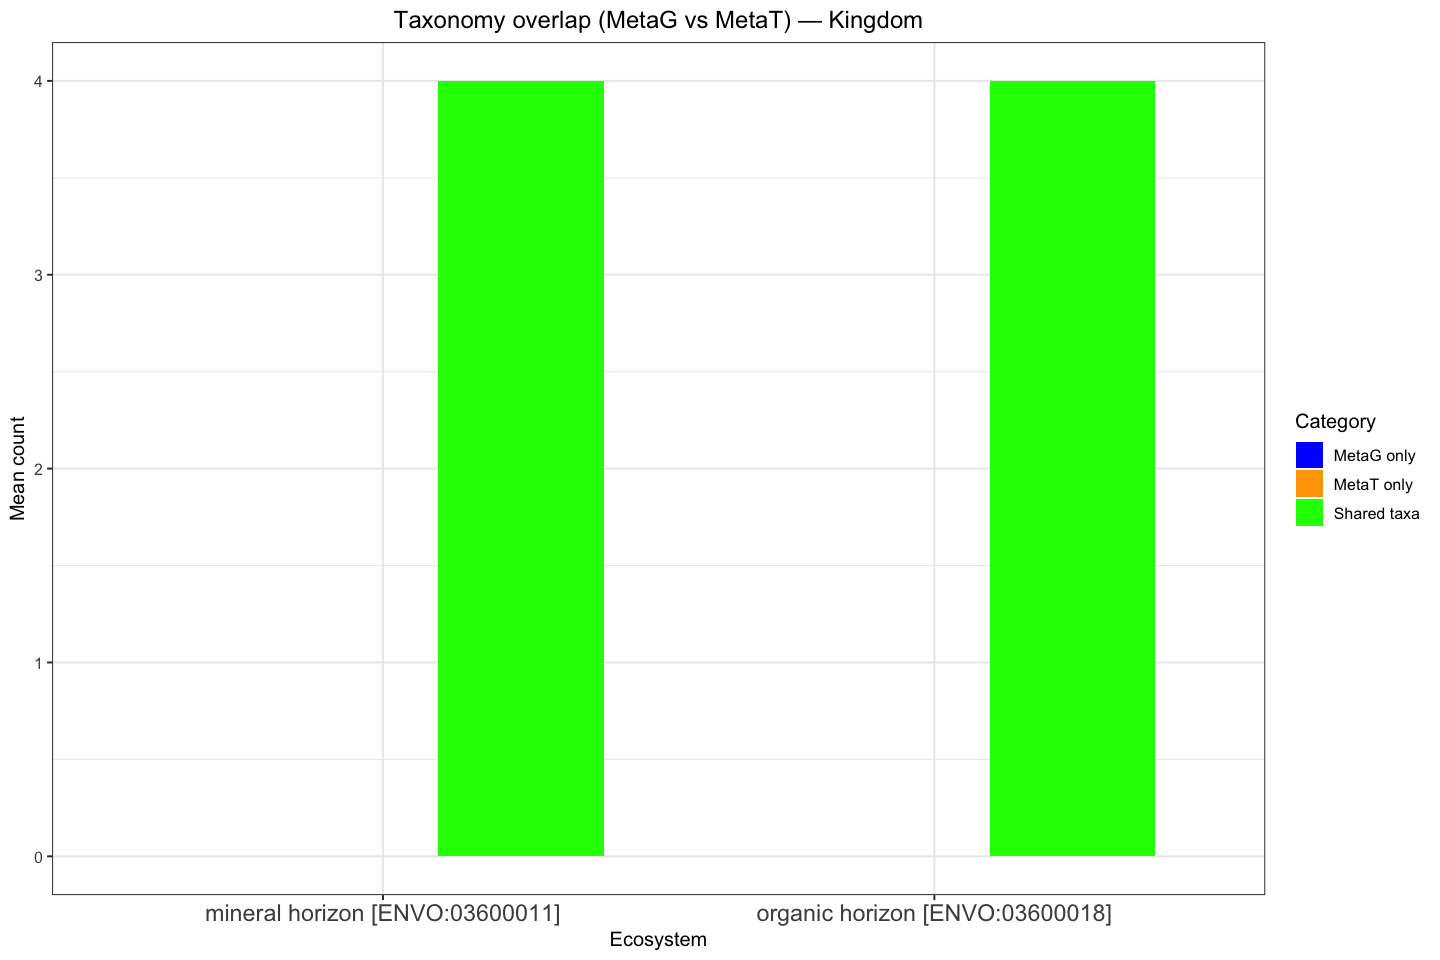

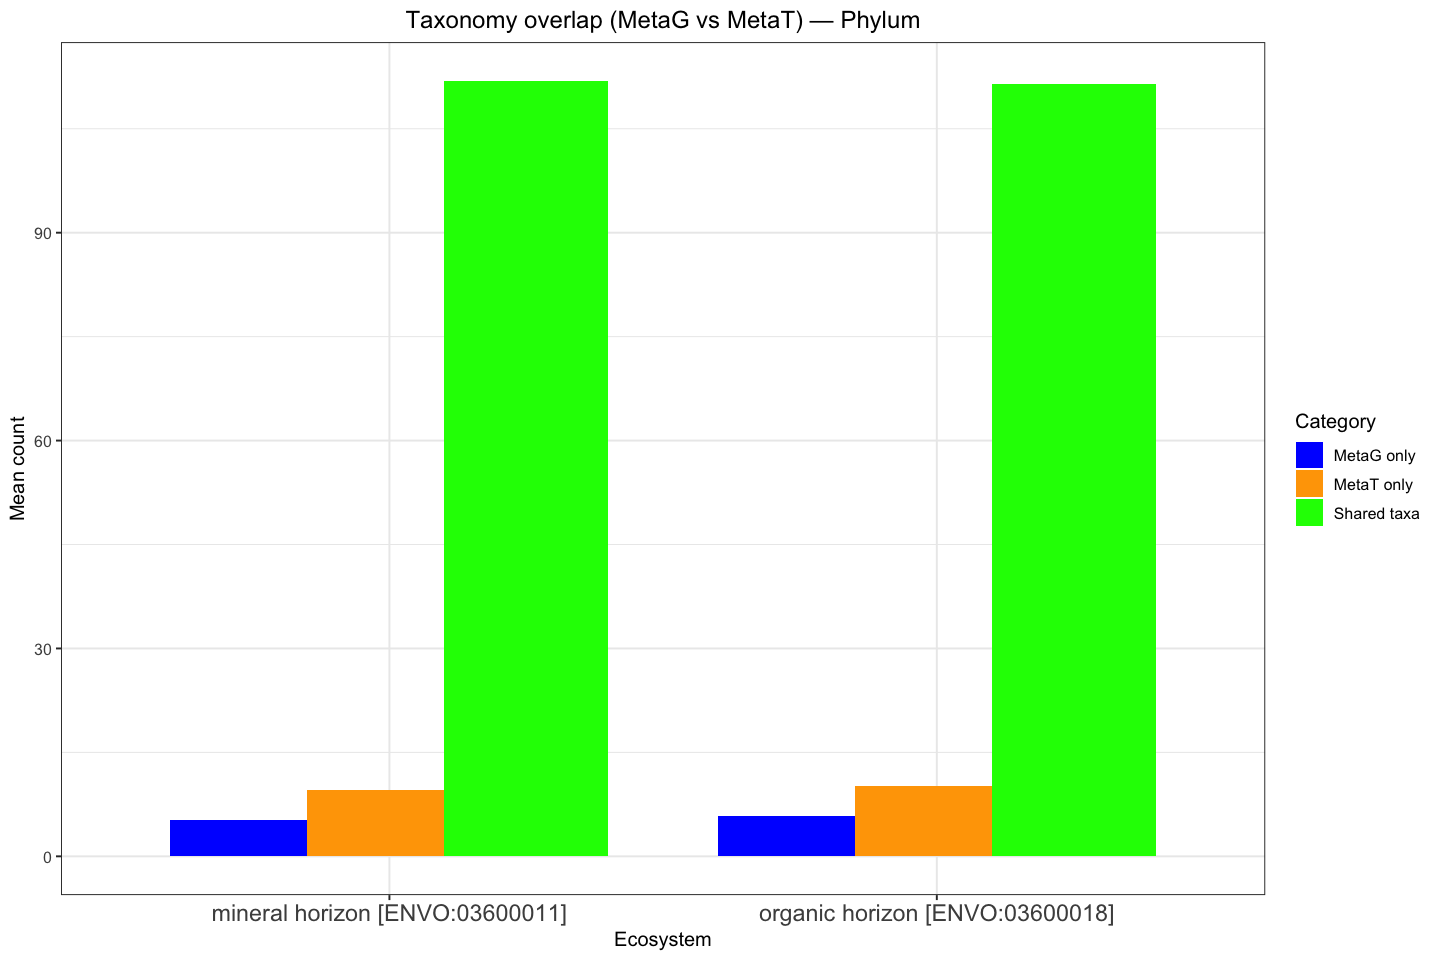

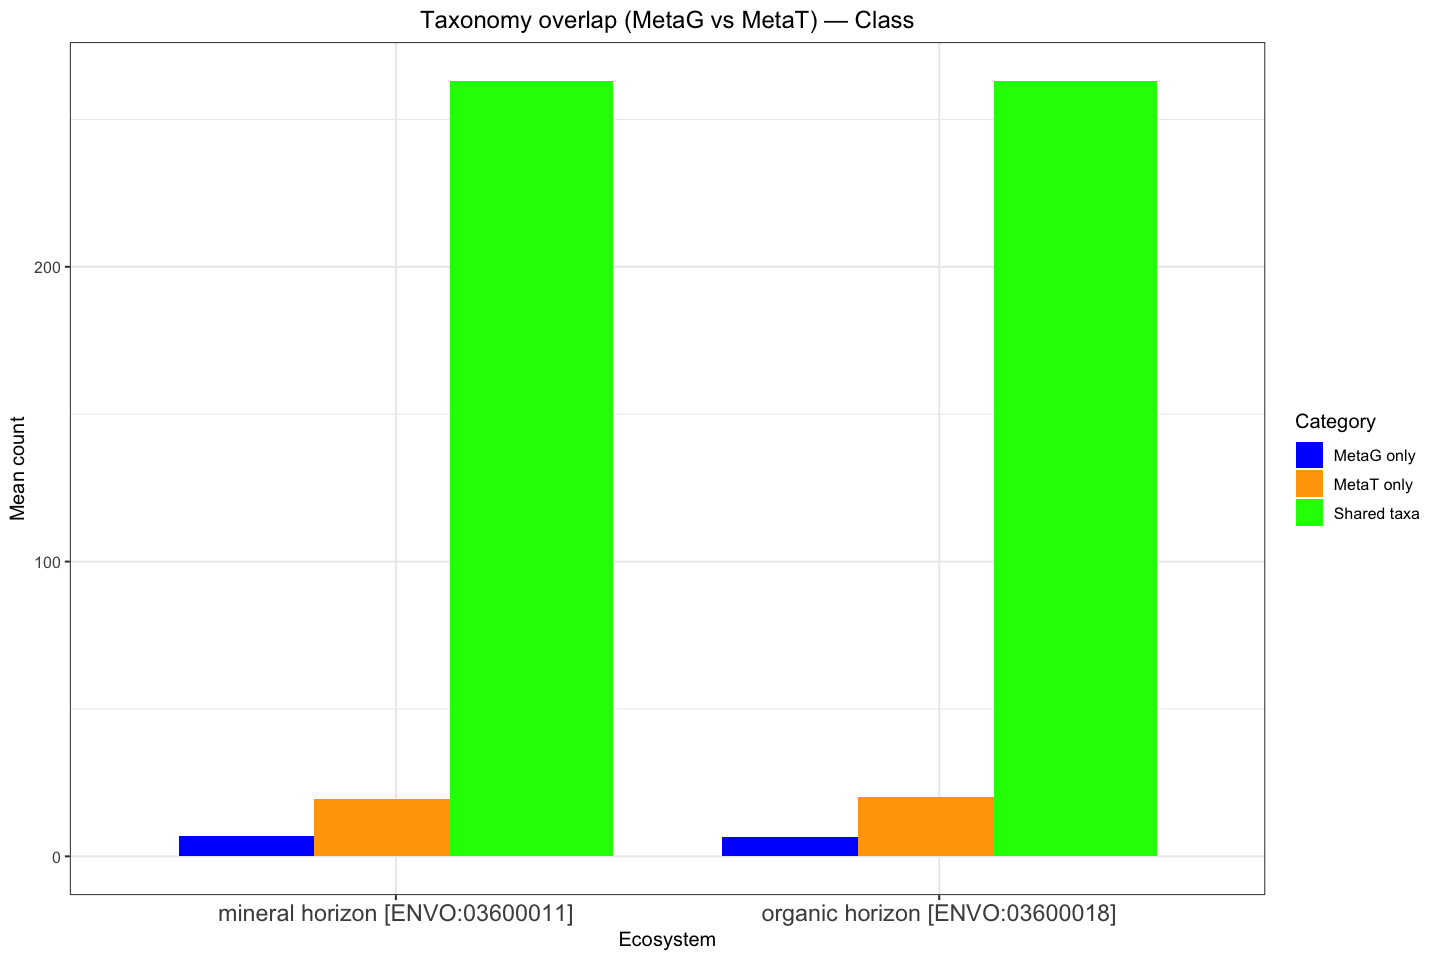

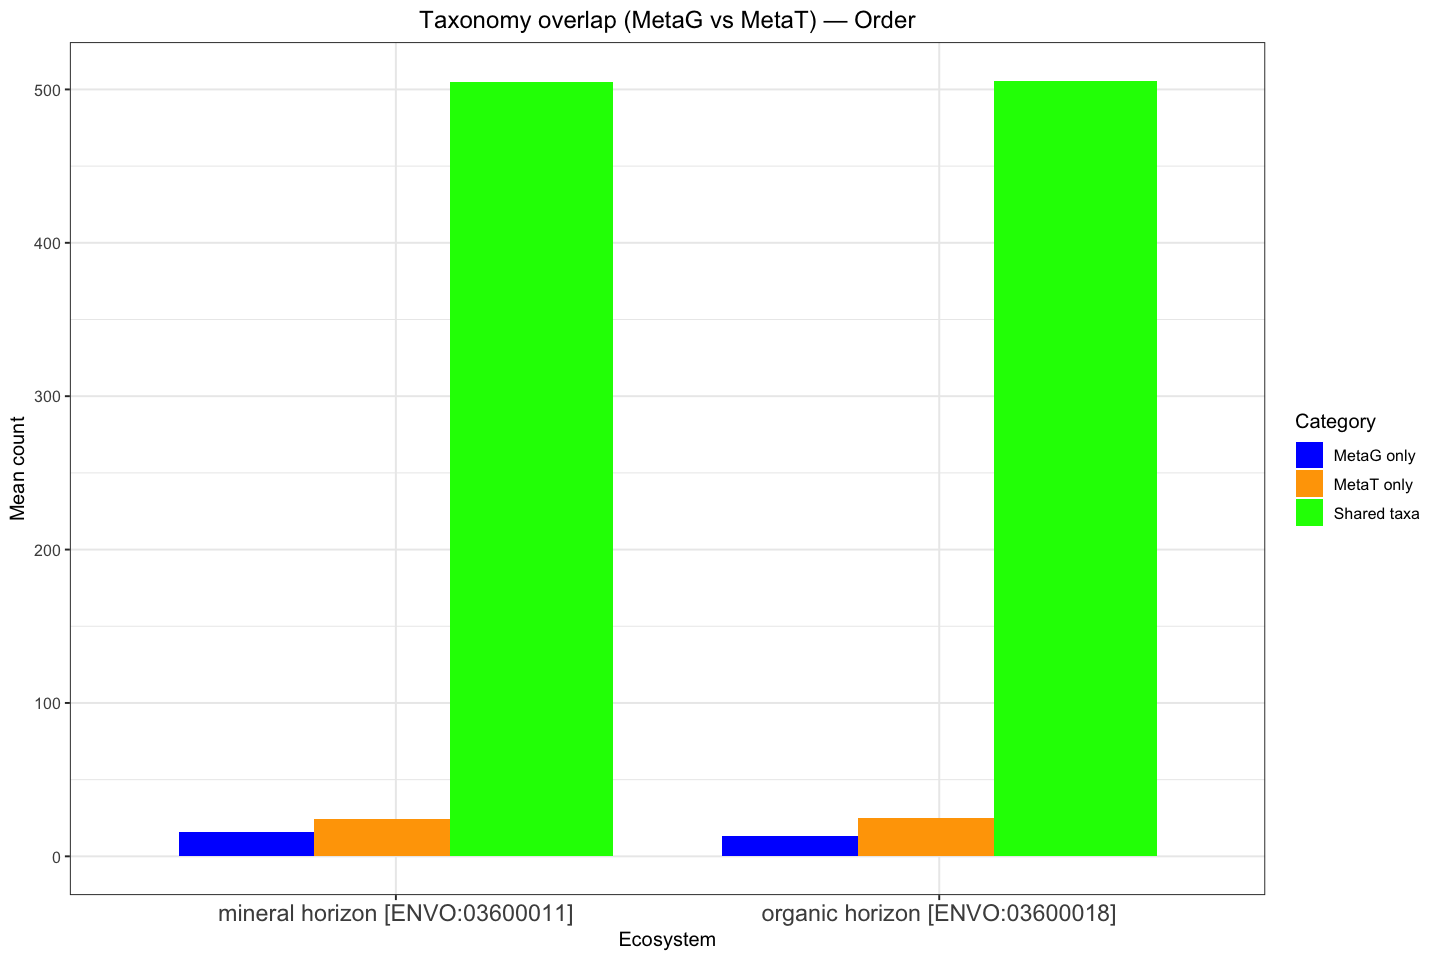

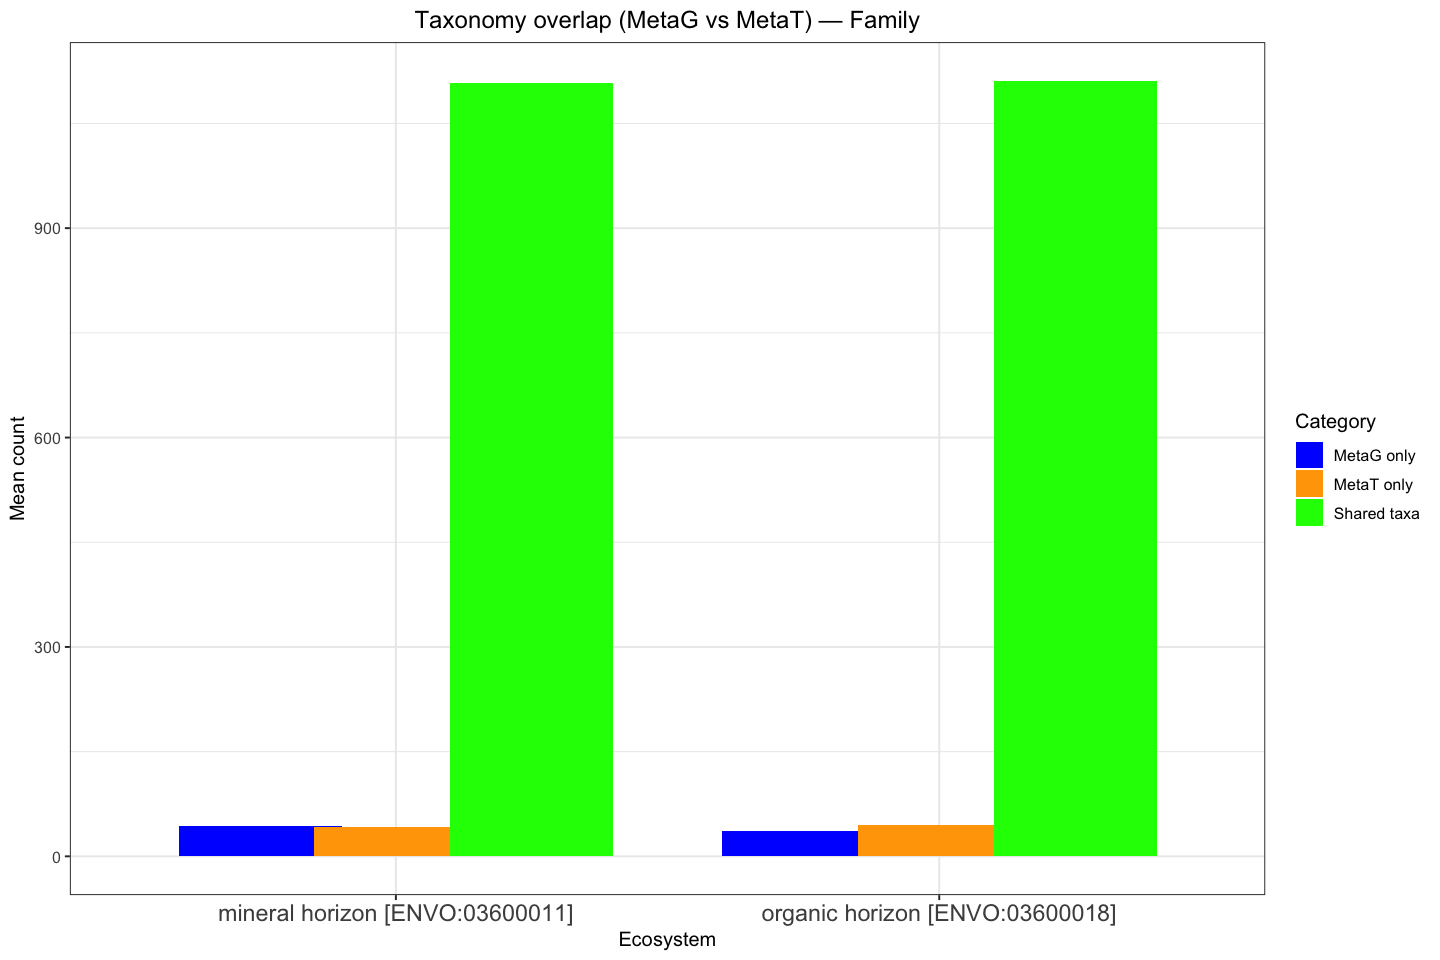

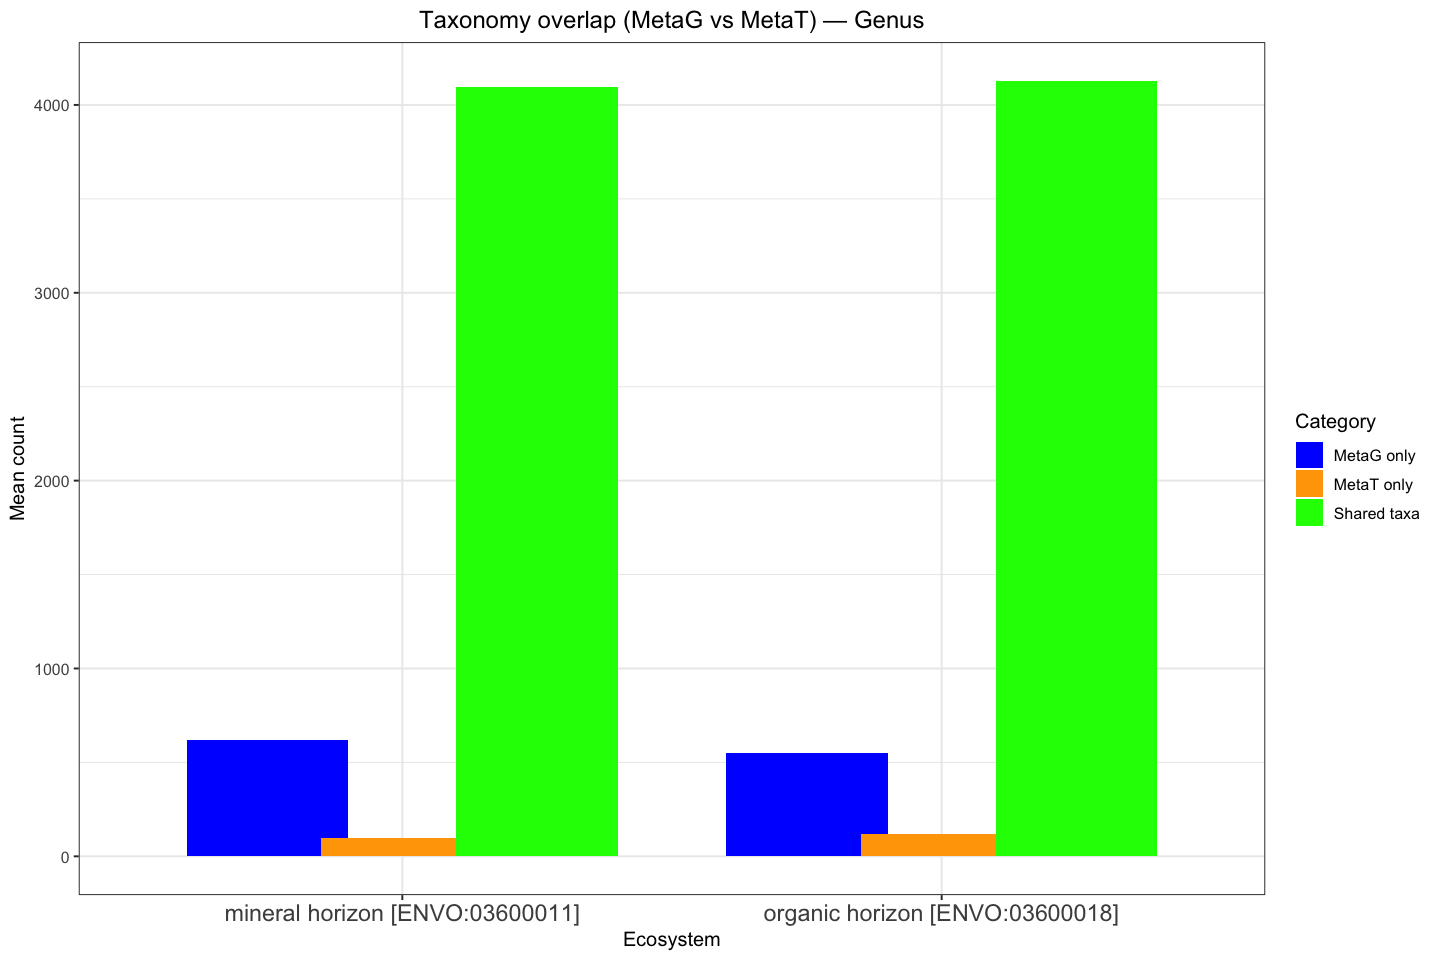

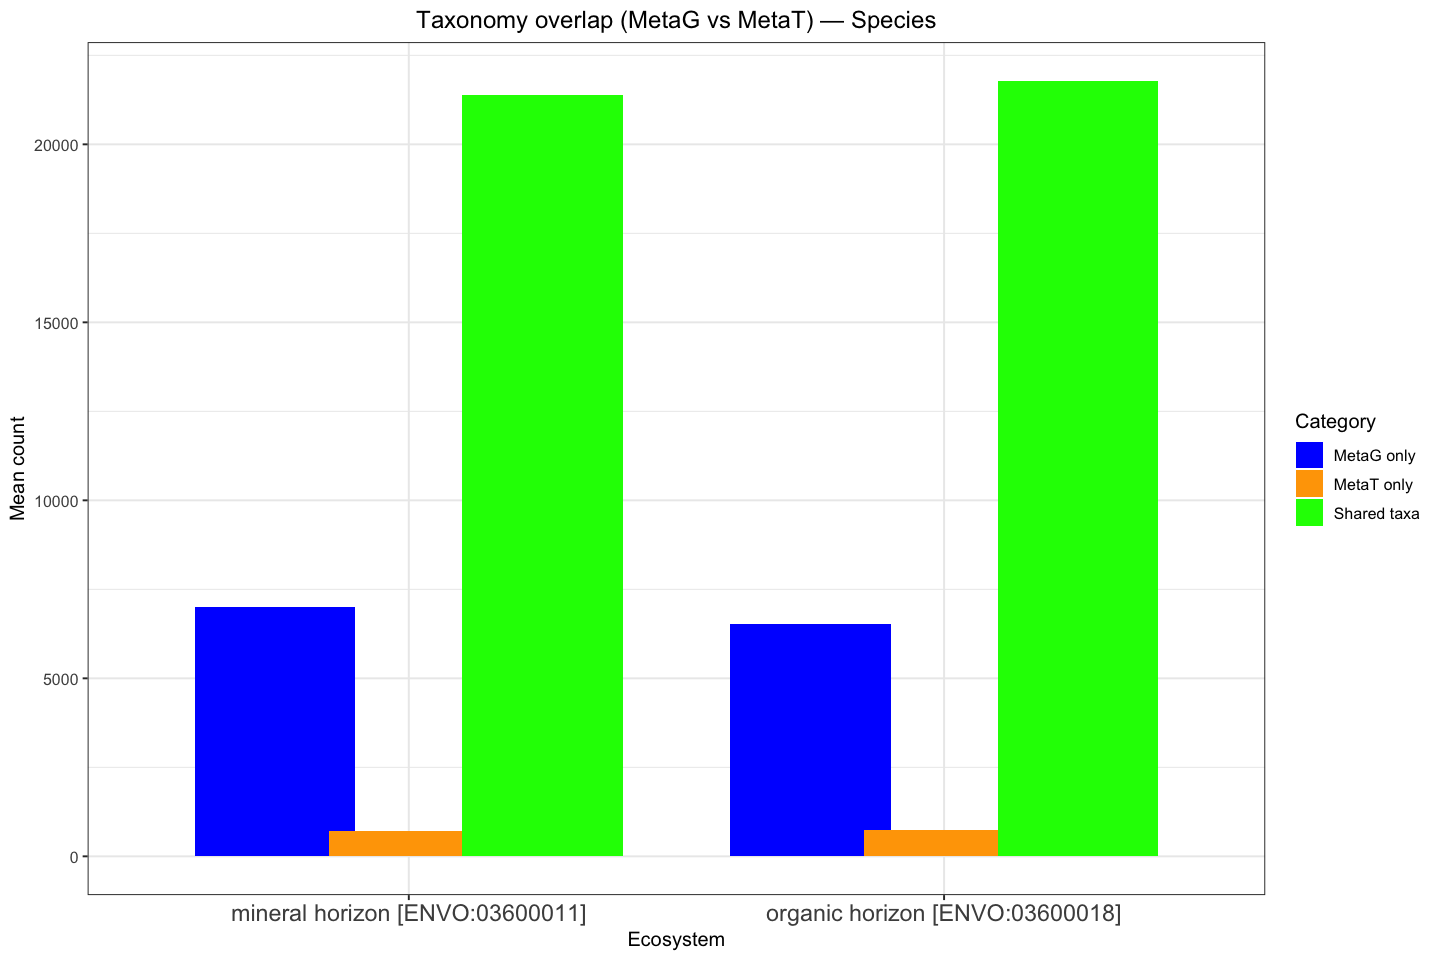

In [53]:
in_csv     <- file.path(OUTPUT_DIR, "taxonomy_overlap_summary.csv")

# ---------- Load tax_overlap_df (prefer file if available) ----------
if (file.exists(in_csv)) {
  tax_overlap_df <- readr::read_csv(in_csv, show_col_types = FALSE)
} else if (!exists("tax_overlap_df")) {
  stop("taxonomy_overlap_summary.csv not found and object `tax_overlap_df` not in memory.")
}

# ---------- Merge metadata ----------
stopifnot(exists("biosample_metadata"))
stopifnot(all(c("biosample_id","env_local_scale") %in% names(biosample_metadata)))

tax_overlap <- tax_overlap_df %>%
  left_join(biosample_metadata %>% select(biosample_id, env_local_scale),
            by = "biosample_id")

# ---------- Aggregate by ecosystem × rank (mean) ----------
agg_overlap <- tax_overlap %>%
  group_by(env_local_scale, rank) %>%
  summarise(
    n_shared_taxa = mean(n_shared_taxa, na.rm = TRUE),
    n_metag_only  = mean(n_metag_only,  na.rm = TRUE),
    n_metat_only  = mean(n_metat_only,  na.rm = TRUE),
    .groups = "drop"
  )

# Rank order for plotting
rank_order <- c("kingdom","phylum","class","order","family","genus","species")

# ---------- Plot per rank (grouped bars) ----------
if (nrow(agg_overlap) > 0) {
  for (r in rank_order) {
    sub <- agg_overlap %>% filter(rank == r)
    if (nrow(sub) == 0) next

    df_long <- sub %>%
      pivot_longer(
        cols = c(n_metag_only, n_metat_only, n_shared_taxa),
        names_to = "category",
        values_to = "mean_count"
      ) %>%
      mutate(
        env_local_scale = factor(env_local_scale),
        category = factor(category,
                          levels = c("n_metag_only", "n_metat_only", "n_shared_taxa"),
                          labels = c("MetaG only", "MetaT only", "Shared taxa"))
      )

    p <- ggplot(df_long, aes(x = env_local_scale, y = mean_count, fill = category)) +
      geom_col(position = position_dodge(width = 0.75)) +
      labs(
        title = paste0("Taxonomy overlap (MetaG vs MetaT) — ", str_to_title(r)),
        x = "Ecosystem",
        y = "Mean count",
        fill = "Category"
      ) +
      scale_fill_manual(values = c("MetaG only" = "blue",
                                   "MetaT only" = "orange",
                                   "Shared taxa" = "green")) +
      theme_bw(base_size = 12) +
      theme(
        axis.text.x = element_text(size=14),
        plot.title = element_text(hjust = 0.5)
      )

    print(p)
  }
} else {
  message("agg_overlap is empty; nothing to plot.")
}

* A substantial block of MetaG-only species is visible in lower ranks, larger than at higher ranks.
* Shared species are still dominant, but the DNA-only fraction suggests many species present in the community are not transcriptionally active under the sampled conditions.


* Ecosystem differences are subtle — the balance of shared vs unique taxa is broadly consistent between mineral horizons and organic horizons


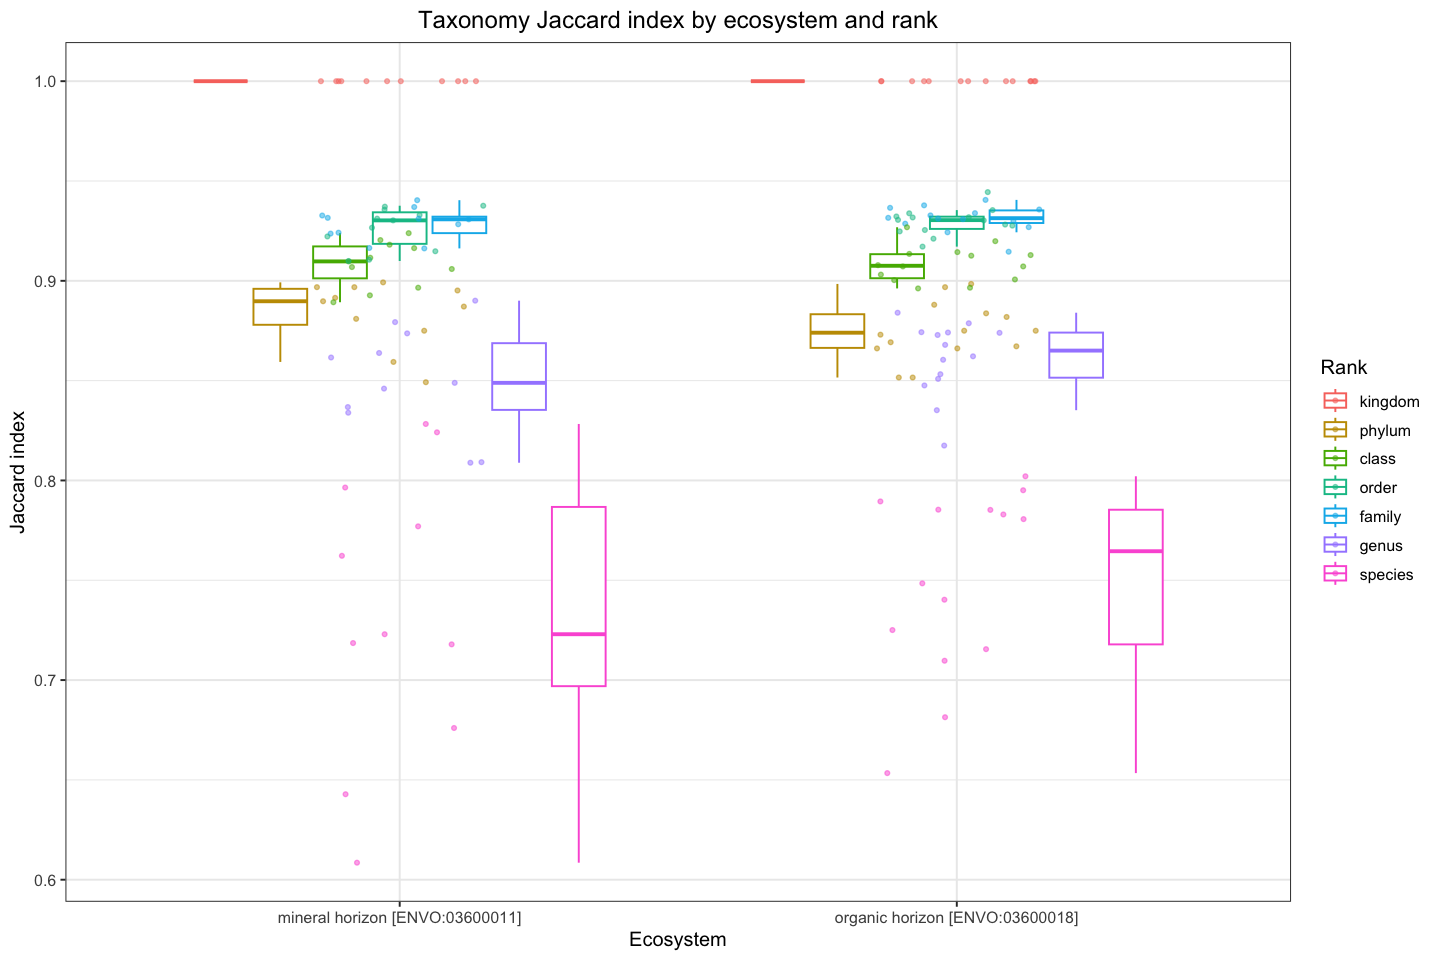

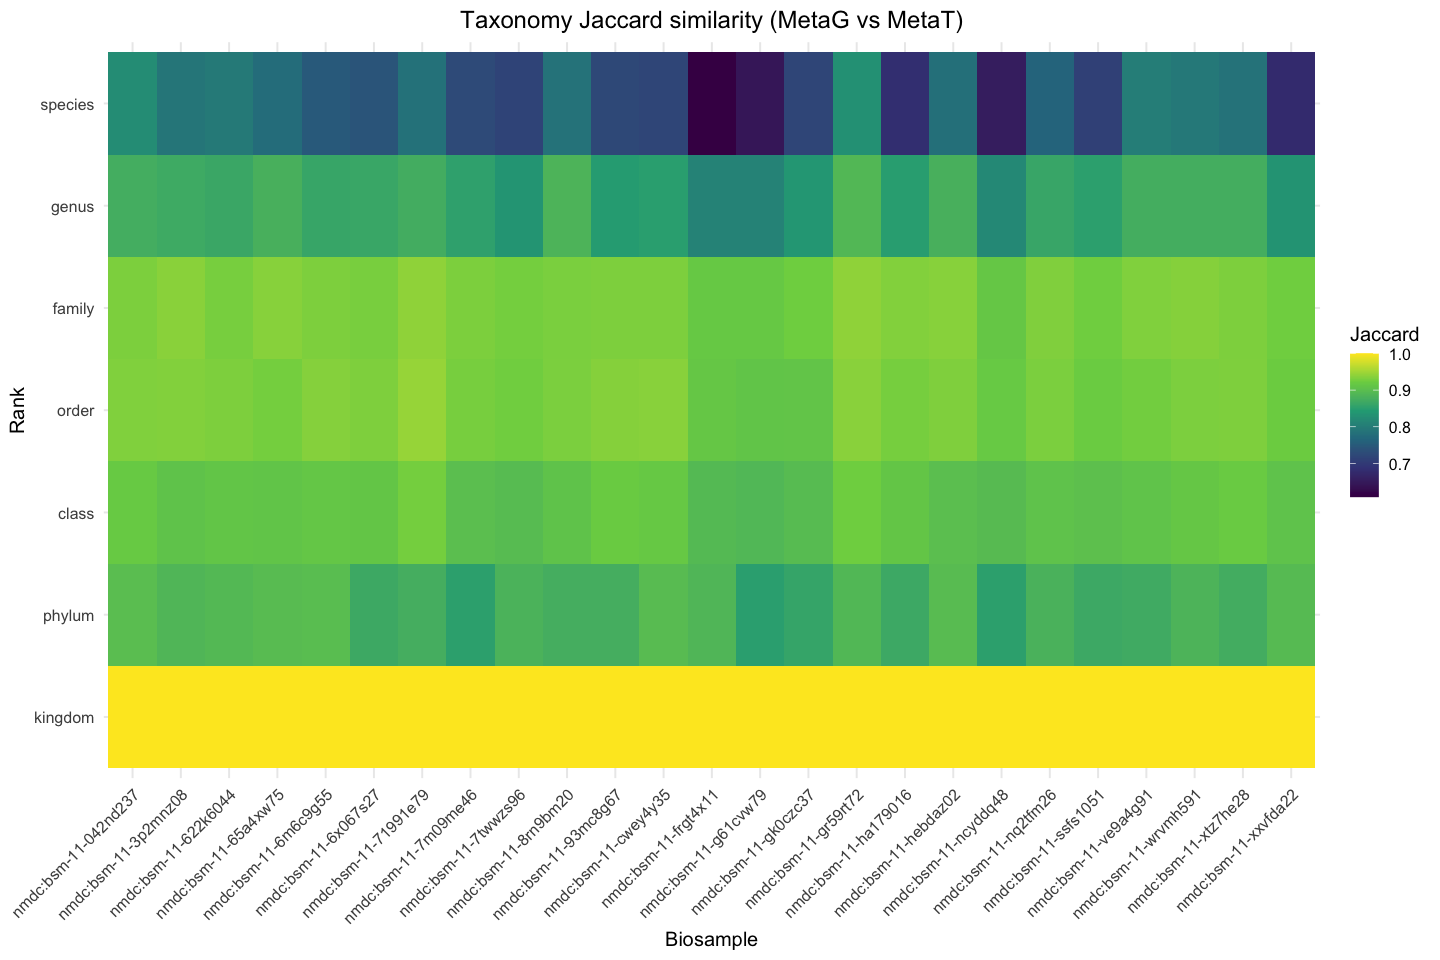

In [54]:
# ---- Load tax_overlap_df if available ----
if (file.exists(in_csv)) {
  tax_overlap_df <- readr::read_csv(in_csv, show_col_types = FALSE)
} else if (!exists("tax_overlap_df")) {
  stop("taxonomy_overlap_summary.csv not found and object `tax_overlap_df` not in memory.")
}

# ---- Merge metadata ----
stopifnot(exists("biosample_metadata"))
stopifnot(all(c("biosample_id","env_local_scale") %in% names(biosample_metadata)))

tax_with_meta <- tax_overlap_df %>%
  left_join(biosample_metadata %>% select(biosample_id, env_local_scale),
            by = "biosample_id")

# ---- Rank order for plotting ----
rank_order <- c("kingdom","phylum","class","order","family","genus","species")

# =========================
# 1) Boxplot of Jaccard by ecosystem (color = rank)
# =========================
if (nrow(tax_with_meta) > 0) {
  p_box <- ggplot(
    tax_with_meta %>% mutate(rank = factor(rank, levels = rank_order)),
    aes(x = env_local_scale, y = jaccard, color = rank)
  ) +
    geom_boxplot(outlier.shape = NA, position = position_dodge2(preserve = "single")) +
    geom_jitter(width = 0.15, alpha = 0.5, size = 1) +
    labs(
      title = "Taxonomy Jaccard index by ecosystem and rank",
      x = "Ecosystem",
      y = "Jaccard index",
      color = "Rank"
    ) +
    theme_bw(base_size = 12) +
    theme(plot.title = element_text(hjust = 0.5))
  print(p_box)
} else {
  message("tax_with_meta is empty; skipping boxplot.")
}

# =========================
# 2) Heatmap of Jaccard (rows = rank, columns = biosample)
# =========================
if (nrow(tax_overlap_df) > 0) {
  # Keep only ranks that appear, in the requested order
  present_ranks <- rank_order[rank_order %in% unique(tax_overlap_df$rank)]

  heat_long <- tax_overlap_df %>%
    filter(rank %in% present_ranks) %>%
    mutate(rank = factor(rank, levels = present_ranks)) %>%
    select(rank, biosample_id, jaccard)

  p_heat <- ggplot(heat_long, aes(x = biosample_id, y = rank, fill = jaccard)) +
    geom_tile() +
    labs(
      title = "Taxonomy Jaccard similarity (MetaG vs MetaT)",
      x = "Biosample",
      y = "Rank",
      fill = "Jaccard"
    ) +
    suppressWarnings(scale_fill_viridis_c(na.value = "grey90")) +
    theme_minimal(base_size = 12) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      plot.title  = element_text(hjust = 0.5)
    )

  print(p_heat)
} else {
  message("tax_overlap_df is empty; skipping heatmap.")
}

* Ecological implication: Microbial communities maintain a stable backbone of active higher taxa, but at the species level, functional activity is more selective and dynamic, likely reflecting fine-scale ecological filtering.
* Many reads that cannot be confidently assigned to species or genus are “backed up” to order or family, where annotation is more reliable.
* At species level, fine-scale ecological filtering (e.g., niche partitioning, dormancy, stress tolerance) kicks in, so only a subset of species are transcribing, dropping overlap.